# Table of Contents

### General Analysis

**Review Analysis** 
* The distribution of average rating 
* Average rating and The number of review through years
* Percentage of good rating(>=4) and bad rating(<4)


**Metadata Analysis** 
* 'nan' values proportion analysis of each feature
* Distribution analysis and visualization of specific features

**Sepecific Analysis**
*  Rating trend of categories through years
*  The number of review for categories change through years

**Correlation**
* Correlation between review quantity and salesRank
* Correlation between review quantity and price

### Key words Analysis 


### Review Sentiment Analysis

- Normalize the range of the sentiment compound score from [-1,1] to [1,5]
- The distribution of sentiment score
- Analysis for the mean sentiment score of each category
- Correlation between rating and sentiment score
- Analysis the difference of rating and sentiment score
    - High rating but low score
    - Low rating but high score
- Find the most popular category according to categories' sentiment score
- Find top10 popular product by using sentiment score 
- [✔]时间变化的受欢迎程度分析(以日、月为单位）
- The trend of popularity with unit date and month


### Special Day Analysis
Take into account that the number of products in each category may influence the reviews
- Consider the average review number for the product in each category 
- Consider the median review number for the product in each category 


Special day analysis in different categoties
- Special  day rating and review for different categories
- Compare Special day rating and review quantity with year's average 
- International Healthy Day
- Christmas Day
- Black Friday

## 1. Import

In [9]:
# Math Packages
import math
import pandas as pd
import numpy as np

# Plot Packages 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline

# #Vader
# import vaderSentiment
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Machine Learning Packages
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn import svm
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# NLP Packages
import spacy
nlp = spacy.load('en')
from gensim.models.phrases import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore

# Other Packages
import pickle
import imageio
import datetime
#from datetime import *
from wordcloud import WordCloud, STOPWORDS
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings 
warnings.simplefilter('ignore')

In [2]:
# File path
DATA_FOLDER = "./data/"
META_HEALTH_CARE = "health_metadata.pkl"
REVIEWS_HEALTH_CARE = "health_review.pkl"
HEALTH_CARE = "health_merge.pkl"
PRODUCT_REVIEW_INFO = "product_review_info.pkl"

## 2. General Analysis

### 2.1 Review Analysis

#### 2.1.1 Load data

In [5]:
# Health care review
df_health_review = pd.read_pickle(DATA_FOLDER+ REVIEWS_HEALTH_CARE)
df_health_review.head()

,asin,helpful,overall,reviewText,ReviewTime
0,0077614992,"[0, 0]",5,This book was a requirement for a college clas...,2013-02-15
1,0615208479,"[0, 0]",5,This is a great gift for anyone who wants to h...,2008-12-01
2,0615269990,"[0, 0]",5,Very helpful in learning about different disea...,2014-04-06
3,0615269990,"[1, 1]",5,Occam's Razor is an unbelievably intuitive and...,2013-12-04
4,0615269990,"[0, 0]",2,I met the guys from Nerdcore at a medical conf...,2014-04-24


#### 2.1.2 Rating distribution

- First, groupby column **asin**(amazon id) and aggregate the average value.
- View the distribution of average rating for dataset with uniqe id.

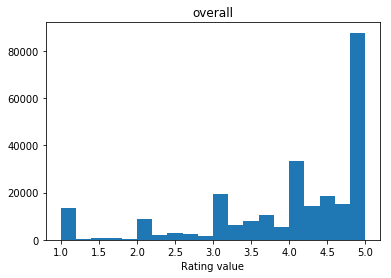

In [6]:
# ratiing average
df_rating_avg = df_health_review.groupby(df_health_review.asin)[['overall']].mean()

# rating distribution
df_rating_avg.hist(bins = 20)
plt.xlabel('Rating value')
plt.grid(False)
plt.show()

⬆From the plot, we know that:
1. the distribution of average rating is consistant.
2. People tend to give a high rating since the number of average rating with a high score is greater. 

#### 2.1.3 Groupby year and get the average rating, good rating ratio,bad rating ratio

- **Good rating **: Rating value > =4  
- **Bad  rating **: Rating value < 4  

In [7]:
# Get the mean and size of rating through 2004-2014 by using groupby year 
df_rating_year_grouped = df_health_review.groupby(df_health_review.ReviewTime.dt.year)['overall']
df_rating_year = df_rating_year_grouped.agg([np.mean,np.size])

# Rename the column mean: avg
df_rating_year.rename({'mean':'avg'},axis='columns',inplace=True)

grouped = df_health_review.groupby(df_health_review.ReviewTime.dt.year)
# Calculate the ratio of Good rating(Rating value > =4)
g = grouped.apply(lambda x: (x[['overall']]>= 4).sum()/x[['overall']].count())
df_rating_year['good_rating_per'] = g['overall']

# Bad rating ratio = 1- Good rating ratio
df_rating_year['bad_rating_per'] = 1- g['overall']

# Filter the number of rating >1000
df_rating_year = df_rating_year[df_rating_year['size']>1200]
df_rating_year

,avg,size,good_rating_per,bad_rating_per
ReviewTime,,,,
2004,3.950674,2595,0.729094,0.270906
2005,3.960867,7155,0.731377,0.268623
2006,4.025686,12458,0.748676,0.251324
2007,4.123946,34757,0.777915,0.222085
2008,4.086907,49570,0.765483,0.234517
2009,4.024734,71116,0.745486,0.254514
2010,4.021525,120416,0.743331,0.256669
2011,4.029847,218313,0.744587,0.255413
2012,4.057568,407486,0.749304,0.250696


In [8]:
# Group by month and sum the review quantity
df_month = df_health_review.set_index('ReviewTime').resample('M').sum().reset_index()
df_month = df_month[df_month.ReviewTime.apply(lambda x:x.year>=2004)]

In [9]:
df_month.head()

,ReviewTime,overall
51,2004-01-31,934
52,2004-02-29,663
53,2004-03-31,550
54,2004-04-30,598
55,2004-05-31,740


#### 2.1.4 Average rating and the number of review through year

- Plot the number of reviews and average rating between 2004-2014 for the whole dataset.

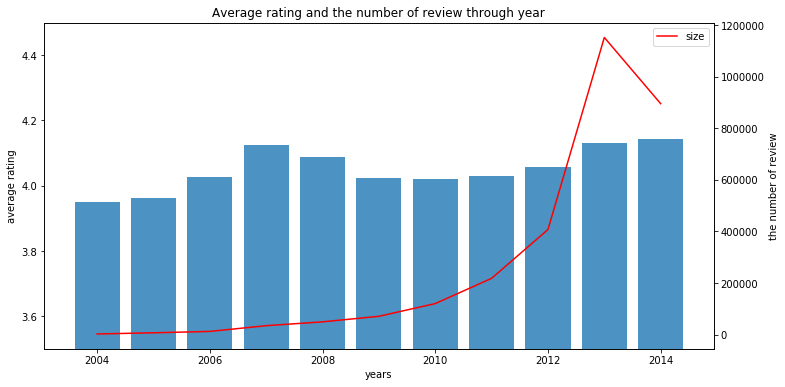

In [6]:
_, ax1 = plt.subplots(figsize = (12,6))
ax1.bar(df_rating_year.index,df_rating_year.avg, alpha=0.8)
ax1.set_ylim(3.5,4.5)
ax1.set_xlabel('years')
ax1.set_ylabel('average rating')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(df_month.index,df_rating_year['size'],color ='r')
ax2.set_ylabel('the number of review')
ax2.legend()
plt.title('Average rating and the number of review through year')
plt.show()

#### 2.1.4 Average rating and the number of review through year

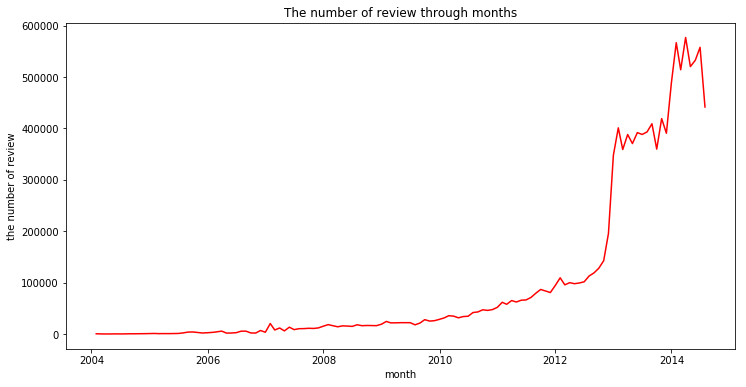

In [11]:
_, ax = plt.subplots(figsize = (12,6))
ax.plot(df_month.ReviewTime.values,df_month.overall.values,color ='r')
ax.set_xlabel('month')
ax.set_ylabel('the number of review')
plt.title('The number of review through months')
plt.show()

#### 2.1.5 Percentage of good rating(>=4) and bad rating(<4) through years

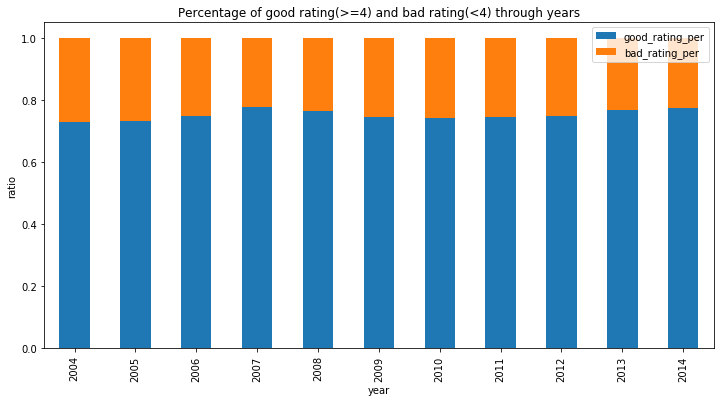

In [12]:
df_rates  = df_rating_year.iloc[:,[2,3]]
_, ax1 = plt.subplots(figsize = (12,6))
df_rates.plot.bar(stacked=True,ax=ax1)
ax1.set_xlabel('year')
ax1.set_ylabel('ratio')
plt.title('Percentage of good rating(>=4) and bad rating(<4) through years')
plt.show()

⬆From the figure above, we know that:
1. The bar plot shows average ratings increase slightly from year 2004 to 2007. After 2007, it decreases a little then grows slowly from 2011 to 2014.
2. The number of review grows from 2004 to 2012 gradually, while after year 2012, it increases dramatically. 
3. As for the reason for the drop in 2013-2014, it is that the health review dataset does not include the whole year review and only records data in several months.

#### 2.1.6 Seasonal review analysis

- As we know from previous part, the number of reviews grows with the years rapidly. However, we hope to dive into the relationship between review number and time. In this part, we apply **seasonal decomposition** method to the observed time series and analyze whether there is a seasonal changing pattern of review number under the yearly growth.

In [13]:
# Create a new DataFrame for review time and the number of reveiw 
df_reviewtime_reveiwnum = df_health_review.groupby('ReviewTime').count()[['asin']]
df_reviewtime_reveiwnum.columns = ['ReviewNumber']
df_reviewtime_reveiwnum = df_reviewtime_reveiwnum.reset_index()

- Since the ammount of review number is too small before 2004 year and the data set seems not to contain the whole sales data in 2014, we only treat the 2004-2013 interval.

In [14]:
flag = df_reviewtime_reveiwnum['ReviewTime'].map(lambda x: (x.year>2003)&((x.year<2014)))
df_reviewtime_reveiwnum_subset = df_reviewtime_reveiwnum.loc[flag]
df_reviewtime_reveiwnum_subset.head()

,ReviewTime,ReviewNumber
832,2004-01-01,14
833,2004-01-02,6
834,2004-01-03,5
835,2004-01-04,10
836,2004-01-05,14


In [15]:
def plot_seasonal_decomposition(df_reviewtime_reveiwnum_subset, seasonal_decomposition_list, title_list, ylabel_list):
    '''
         Plot seasonal decomposition figures: 
         Initial Time Series Figure, Trend Component Figure, Seasonal Component Figure.
    '''
    for i in range(3):
        plt.subplot(3,1,i + 1)
        plt.plot(df_reviewtime_reveiwnum_subset.ReviewTime, seasonal_decomposition_list[i])
        plt.xlabel('Date')
        plt.ylabel(ylabel_list[i])
        plt.title(title_list[i])
        plt.legend(['Data Change Line'])
    plt.show()

- The [decomposition of time series](https://en.wikipedia.org/wiki/Decomposition_of_time_series) is a statistical task that deconstructs a time series into several components, each representing one of the underlying categories of patterns:
$$
y_t = T_t + C_t + S_t + I_t
$$<br>
$T_t$: the trend component at time $t$. &nbsp;&nbsp;&nbsp;&nbsp; $C_t$: the cyclical component at time $t$.&nbsp;&nbsp;&nbsp;&nbsp;
$S_t$: the seasonal component at time $t$.&nbsp;&nbsp;&nbsp;&nbsp;$I_t$: the irregular component at time $t$.<br>

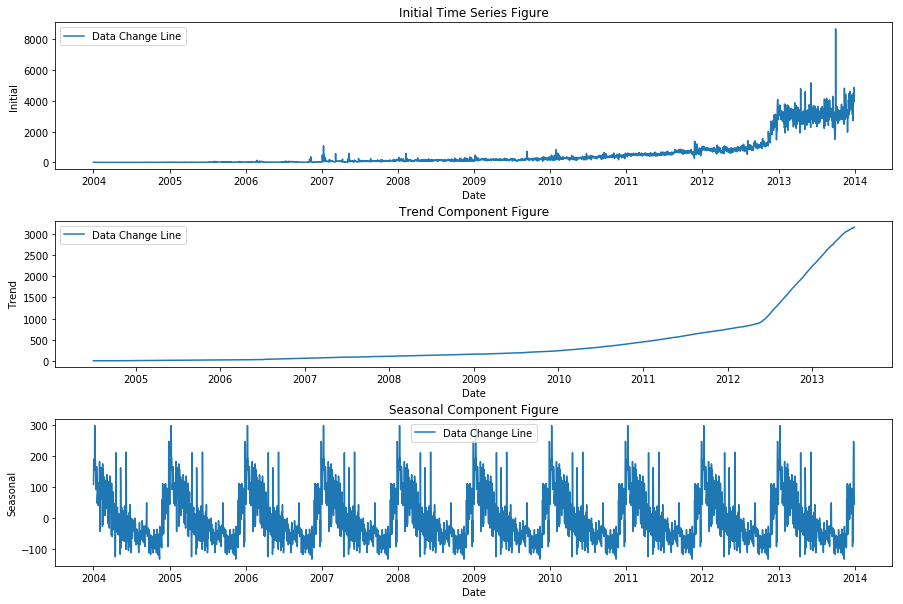

In [16]:
seasonal_decomposition = seasonal_decompose(df_reviewtime_reveiwnum_subset.ReviewNumber,freq=365)

fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=0.35)
title_list = ['Initial Time Series Figure', 'Trend Component Figure', 'Seasonal Component Figure']
ylabel_list = ['Initial', 'Trend', 'Seasonal']

seasonal_decomposition_list = [seasonal_decomposition.observed, seasonal_decomposition.trend, 
                              seasonal_decomposition.seasonal, seasonal_decomposition.resid]

plot_seasonal_decomposition(df_reviewtime_reveiwnum_subset, seasonal_decomposition_list, title_list, ylabel_list)

⬆From the figures above, we know that:
1. There is a remarkable increasing trend of review number and the growth rate is becoming more and more faster with the years.
2. There exists a yearly seasonal trend, which reaches its peaks around January and September and drops to its lowest point around June.

###  2.2 Metadata

- In this part, we analysis features including 'brand', 'salesrank'. Because all of them contain 'nan' values, we count the number of 'nan' values first and then we do other analysis according to the this percentage.
- For example, if the 'nan' values occupies large section in the this feature, we may not consider to do further analysis on this feature while we will discover more deeper in the data if the percentage is small.
- For 'price' and 'helpful', the former one we has replaced 'nan' with 0.

In [17]:
# Read data
health_care_meta = pd.read_pickle(DATA_FOLDER + META_HEALTH_CARE)

#### 2.2.1 Brand

In [18]:
# count the number of data with 'nan' values
health_care_meta['brand'].isnull().value_counts()

True     138121
False    124196
Name: brand, dtype: int64

⬆As is shown above:
1. The number of 'nan' value in brand columns exceed 50%. 
2. This result may because some products on Amazon are sold by individual or some brands are not popular enough to group the products into their brand. 
3. If we just analyse the rest of data, it will have large bias.Therefore, we decide not to do any analysis what influence brand brought to and the co-relationship between brand and other features.

#### 2.2.2 SalesRank

In [19]:
# count the number of data with 'nan' values
health_care_meta['salesRank'].isnull().value_counts()

False    246999
True      15318
Name: salesRank, dtype: int64

⬆As is shown above:
1. 'nan' value in salesrank just occupies very small part, so we can do deep analysis on this feature.

- As we notice that in the salesrank columns, the ranks of some products don't belong to the 'Health & Personal Care' category (**shown below**). Therefore, in this part, we want to get the counts of each category in the salerank and calculate the proportion of the categories that we're interested and also plot the distribution of the categories.

In [20]:
health_care_meta.iloc[2]

title                                             Occam's Razor
related       {'also_bought': ['1935660152', '0071743979', '...
salesRank                              {'Toys & Games': 110575}
categories    [[Health & Personal Care, Personal Care, Shavi...
price                                                     34.99
brand                                                       NaN
Name: 0615269990, dtype: object

⬆From above, we also notice that:
1. The values in the salesrank are not only typical dictionary format and 'nan' value but also many empty dictionary (which is '{}'). 
2. This type of values will be converted into 'nan'.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Main Function**:
- `count_abnormal`: to get the counts of abnormal data, i.e. empty dictionary in this case. ('nan' is actually in float type,so checking data if it is float means checking if it is 'nan')
- `deal_emptydict`: to convert empty dictionary into 'nan' value.
- `count_salerank`: to count each category shown in salesrank.
- `select_salerank`: to select category that we want from data.

In [21]:
def count_abnormal(meta_df):
    """
    count the number of data which contains empty dictionary.

    Parameter:
        meta_df (pandas.dataframe): dataframe that need to process
        
    Return:
        null
    """
    # Initial count
    null_dict_count,notfloat_count=0,0
    for ind,salerank in enumerate(meta_df['salesRank'].values):
        # for dictionary
        if(type(salerank).__name__=='dict'):
            # for empty dictionary
            if(len(salerank)==0):
#                 print("Len(salerank)==0:{s}".format(s=salerank))
                null_dict_count += 1
        # for 'nan' value
        elif((type(salerank).__name__!='float')): 
#             print("float type:{s},type:{t}".format(s=salerank,t=type(salerank).__name__))
            notfloat_count +=1
    # print out
    print("The counts of empty dictionary: " + str(null_dict_count))
    print("The counts of figures which is not float and not dictionary: " + str(notfloat_count))

In [22]:
def deal_emptydict(meta_df):
    """
    Convert empty dictionary value into 'nan'
    
    Parameter:
        meta_df (pandas.dataframe): dataframe that need to process
    
    Return:
        null
    """
    for ind,salerank in enumerate(meta_df['salesRank'].values):
        if(type(salerank).__name__=='dict'):
            if(len(salerank)==0):
                meta_df['salesRank'].values[ind] = np.nan

In [23]:
def count_salerank(meta_df):
    """
    Count the number of category shown in salesrank.
    
    Parameter:
        meta_df (pandas.dataframe): dataframe that need to process
        
    Return:
        sale_cat (dict): dictionary contains categories' name and their counts
    """
    sale_cat={}
    for ind,salerank in enumerate(meta_df['salesRank'].values):
        # for 'nan' value
        if (type(salerank).__name__=='float'):
            if (math.isnan(salerank)):
                if('NAN' in sale_cat):
                    sale_cat['NAN'] +=1
                else:
                    sale_cat['NAN'] = 1
            else:
                print(salerank)
                break
        # for dictionary
        elif(type(salerank).__name__=='dict'):
            # get key
            key = list(salerank.keys())[0]
            # check if sale_cat contains this key
            if(key in sale_cat):
                sale_cat[key] +=1
            else:
                sale_cat[key] = 1
        else:
            print(salerank)
            break
    return sale_cat

In [24]:
def select_salerank(meta_df,catname):
    """
    Select data that belongs to right category in salesrank.
    
    Parameter:
        meta_df (pandas.dataframe): dataframe that need to process
        catname (string): selected category's name
        
    Return:
        array of data's index
    """
    rowlist=[]
    for i in range(len(meta_df)):
        if(type(meta_df.iloc[i]['salesRank']).__name__=='dict'):
            # Get key
            key = list(meta_df.iloc[i]['salesRank'].keys())[0]
            if (key ==catname):
                # find index
                idx = (meta_df.iloc[[i]]).index.values[0]
                rowlist.append(idx)
    return np.asarray(rowlist)

In [25]:
# show the number of data with empty dictionary value
count_abnormal(health_care_meta)

The counts of empty dictionary: 470
The counts of figures which is not float and not dictionary: 0


In [26]:
# process abnormal data
deal_emptydict(health_care_meta)
count_abnormal(health_care_meta)

The counts of empty dictionary: 0
The counts of figures which is not float and not dictionary: 0


- Count categories in salerank and show.

In [27]:
hc_countcatsale = count_salerank(health_care_meta)
hc_countcatsale

{'Arts, Crafts & Sewing': 849,
 'Automotive': 44,
 'Baby': 61,
 'Beauty': 15209,
 'Books': 1,
 'Camera &amp; Photo': 58,
 'Cell Phones & Accessories': 1,
 'Clothing': 2788,
 'Computers & Accessories': 5,
 'Electronics': 667,
 'Grocery & Gourmet Food': 96,
 'Health & Personal Care': 193734,
 'Home &amp; Kitchen': 12447,
 'Home Improvement': 252,
 'Industrial & Scientific': 4111,
 'Jewelry': 433,
 'Kitchen & Dining': 5363,
 'Movies & TV': 5,
 'Music': 15,
 'Musical Instruments': 60,
 'NAN': 15788,
 'Office Products': 61,
 'Patio, Lawn & Garden': 665,
 'Pet Supplies': 765,
 'Shoes': 689,
 'Software': 18,
 'Sports &amp; Outdoors': 6129,
 'Toys & Games': 1939,
 'Video Games': 4,
 'Watches': 60}

- Plot to see the distribution of each category.

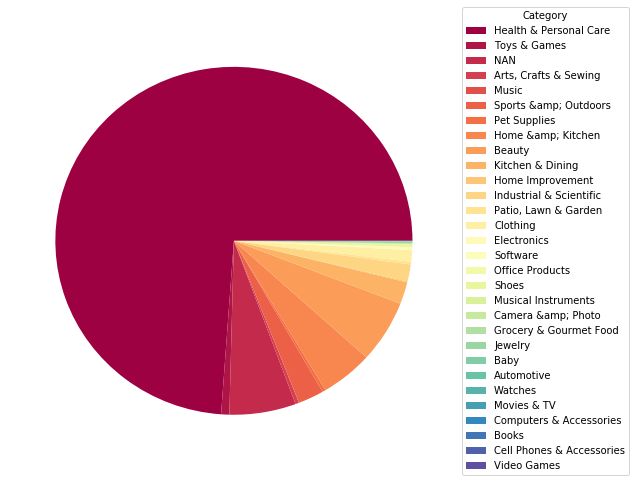

In [28]:
# get categories' name
health_cat = list(hc_countcatsale.keys())
# get counts
health_salerankcount = list(hc_countcatsale.values())

# select color for plot
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, len(health_cat))]

fig,ax= plt.subplots(figsize=(8, 8))
wedges, texts = ax.pie(health_salerankcount,colors=colors)

ax.legend(wedges, health_cat,
          title="Category",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

⬆As the pie chart shown above:
1. It is obvious that the 'Health & Personal Care' category occupies the largest section in this data-set while each of the others just represented in small parts.<br>

- We calculate the percentage of 'Health & Personal Care' category to show more clearly.

In [29]:
print("The proportion of products in the corresponding category's salerank: {p:.3f}%"
     .format(p=hc_countcatsale['Health & Personal Care']*100/len(health_care_meta)))

The proportion of products in the corresponding category's salerank: 73.855%


⬆Conclusion can be drawn that:
1. We can analysis the influence brought by salesrank afterwards or the co-relationship between salesrank and other feature.<br>

- Select row with interested category in salesrank.

In [30]:
# Select the index of data which we are interested for later analysis
hc_row = select_salerank(health_care_meta,'Health & Personal Care')
#Check if all the desired data is selected
len(hc_row)

193734

In [31]:
health_valid_salerank = health_care_meta.loc[hc_row]

####  2.2.3 Price

For price, we calculate the number of data with 0 value first and then view its statistic to analyse.

In [32]:
print("The proportion of 0 price in Health & Care is {p:.3f}%".
      format(p=len(health_care_meta[health_care_meta['price']==0])*100/len(health_care_meta)))

The proportion of 0 price in Health & Care is 25.462%


⬆The percentage of 'nan' is not too large and we can consider to make some analysis on this feature.

In [33]:
# View the statistic of price.
health_valid_price = health_care_meta[health_care_meta['price']!=0]
health_valid_price.describe()

,price
count,195526.000000
mean,28.602098
std,46.342271
min,0.010000
25%,9.250000
50%,17.000000
75%,30.980000
max,999.990000


⬆From the minimum and maximum of price, we can know that:
1. The valid price in health&care range from 0.01 to 999.99. Actually, We also analysed the Sports&Outdoors data-set (but decided not to use it for the reason shown in README.md), which is shown below and shows that the range of price is the same as the Health&Care's one. <br/>
<img src="sports_price.jpg" alt="sports_price" width="500" hight="200"/><br/>
2. Furthermore, since we have filter the 0 value with which we replace 'nan', and there is no item with 0 price in reality, we can make an assumption that the price of original data-set just accept 0.01 to 999.99 dollars and the rest,the original 'nan' value are actually larger than 999.99 or the price has been normalized between 0 and 999.99 but some data are missed in this process and thus became 'nan'.

- Plot the distribution of price in log-log scale.

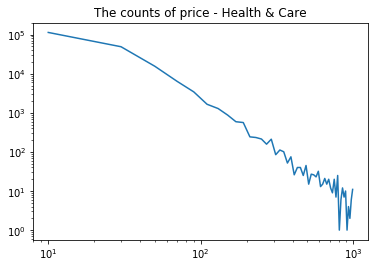

In [34]:
count_log, bin_edges =np.histogram(health_valid_price['price'],bins=50)
# middle points of bins
bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
plt.loglog(bin_centers,count_log,'-')
plt.title("The counts of price - Health & Care")
plt.show()

⬆From the plot, it is clear that:
1. It shows in power-law style and most of products in Health&Care are in low price while the products with high price are extremely few. 
2. This result fits the reality as we know most of the products are cheaper online because they are tough enough to ship and many people prefer to buy online because of the low price. However, many expensive products are usually more available in the physical store.

####  2.2.4 Helpful

- In this part, we analysis features including 'brand', 'salesrank'. Because all of them contain 'nan' values, we count the number of 'nan' values first. But for 'price' and 'helpful', the former one we has replaced 'nan' with 0 and the latter one contain helpfulness voting which may be 0. Therefore, we calculate the proportion of 0 values in these two features first. And then we do other analysis according to results.
- For example, if the 'nan' values occupies large section in the this feature, we may not consider to do further analysis on this feature while we will discover more deeper in the data if the percentage is small.

In [35]:
# count of 0 helpfulness voting
health_helpszero_count = 0
for helps in df_health_review['helpful'].values:
    if (helps[1]==0):
        health_helpszero_count += 1

print("The count of 0 helpfulness voting is: " + str(health_helpszero_count))

The count of 0 helpfulness voting is: 1613817


In [36]:
print("The proportion of 0 helpfulness voting is : {p:.3f}%".format(p=health_helpszero_count*100 / len(df_health_review['helpful'].values)))

The proportion of 0 helpfulness voting is : 54.279%


⬆As shown above:
1. The percentage of 0 helpfulness is so high, which means that most people in Amazon do not vote review because they do not have this habit or the review is useless for them. 
2. We cannot draw a conclusion on which assumption is right, so we will not do any analysis on this feature afterwards.

#### 2.2.5 Merge metadata and review data 

In [37]:
df_health_meta = health_care_meta.copy()
df_merge_health = df_health_review.merge(df_health_meta, how ='inner', left_on='asin',right_index=True)
df_merge_health.to_pickle(DATA_FOLDER + HEALTH_CARE)

### 2.3. Specific Analysis

#### 2.3.1 Load the dataset

In [33]:
df_health_merge_review = pd.read_pickle(DATA_FOLDER + HEALTH_CARE)
df_health_merge_review.head(3)

,asin,helpful,overall,reviewText,ReviewTime,title,related,salesRank,categories,price,brand
0,0077614992,"[0, 0]",5,This book was a requirement for a college clas...,2013-02-15,Principles of Mgmt + Oper-CSUF Custom C,"{'also_bought': ['0471730726', '0132834871', '...",{'Health & Personal Care': 168429},[[Health & Personal Care]],0.00,NaN
1,0615208479,"[0, 0]",5,This is a great gift for anyone who wants to h...,2008-12-01,Brain Fitness Exercises Software,NaN,{'Health & Personal Care': 1346973},"[[Health & Personal Care, Personal Care]]",0.00,NaN
2,0615269990,"[0, 0]",5,Very helpful in learning about different disea...,2014-04-06,Occam's Razor,"{'also_bought': ['1935660152', '0071743979', '...",{'Toys & Games': 110575},"[[Health & Personal Care, Personal Care, Shavi...",34.99,NaN


#### 2.3.2 Split the category into several **sub-categories**.  

- For example, Split [ ['Health & Personal Care',
  'Personal Care',
  'Shaving & Hair Removal',
  'Manual Shaving'] ] into 4 class  
- 1st category is : 'Health & Personal Care'  
- 2nd category is : 'Personal Care'  
- 3rd category is : 'Shaving & Hair Removal'  
- 4th category is : 'Manual Shaving'

In [34]:
df_health_merge_review.categories[2]

[['Health & Personal Care',
  'Personal Care',
  'Shaving & Hair Removal',
  'Manual Shaving']]

In [35]:
# split the category into several sub-categories
health_cat = df_health_merge_review.categories.apply(lambda x : x[0]).values.tolist()
df_health_category = pd.DataFrame(health_cat)
df_health_category.columns = ['1st','2nd','3rd','4th','5th','6th','7th']
df_health_category.head()

,1st,2nd,3rd,4th,5th,6th,7th
0,Health & Personal Care,None,None,None,None,None,None
1,Health & Personal Care,Personal Care,None,None,None,None,None
2,Health & Personal Care,Personal Care,Shaving & Hair Removal,Manual Shaving,None,None,None
3,Health & Personal Care,Personal Care,Shaving & Hair Removal,Manual Shaving,None,None,None
4,Health & Personal Care,Personal Care,Shaving & Hair Removal,Manual Shaving,None,None,None


⬆Since the 1st sub-categories always is ```Health & Personal Care```, we would like to analyze the 2nd sub-categories, and find the average rating and review quantity through years based on this.

####  2.3.3 Missing rate of 2nd sub-categories

- First, we calcalate the missing rate of 2nd sub-categories. If the missing rate is small we can ignore it since it will have not influnce to out analysis.

In [36]:
# None value rate 
missing_2nd = df_health_category[df_health_category.iloc[:,1].isnull()]['1st'].count()/df_health_category.shape[0]
print( 'Missing rate of 2nd sub-categories is {:.2f}%'.format(missing_2nd*100))

Missing rate of 2nd sub-categories is 2.80%


In [37]:
df_health_category['asin'] = df_health_merge_review.asin
df_health_category['overall'] = df_health_merge_review.overall
df_health_category['time'] = df_health_merge_review.ReviewTime

- ```Groupby``` the 2nd sub-categories and calculate the average rating and review quantity

In [38]:
rating_avg = df_health_category.groupby('2nd')[['overall']].mean().sort_values('overall',ascending = False)
review_quantity = df_health_category.groupby('2nd')[['overall']].count().sort_values('overall',ascending = False)

#### 2.3.4 Average rating score for each category

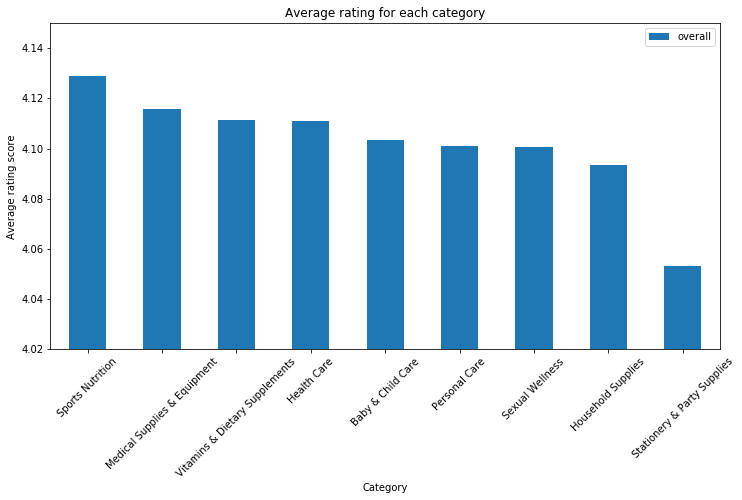

In [39]:
_, ax1 = plt.subplots(figsize = (12,6))
rating_avg.plot.bar(ax=ax1,rot=45)
ax1.set_xlabel('Category')
ax1.set_ylabel('Average rating score')
plt.title('Average rating for each category')
ax1.set_ylim(4.02,4.15)
plt.show()

⬆The above plot shows that:
1. category Sports Nutrition have the highest average rating and people are not satifiied with the product related Stationery & Party Supplies. 
2. The differences among other categories's average rating are small. 

#### 2.3.5 Review quantity for each category

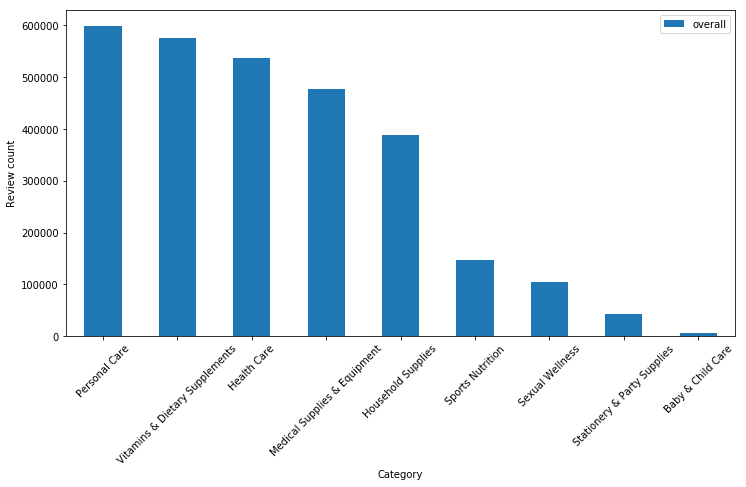

In [40]:
_, ax1 = plt.subplots(figsize = (12,6))
review_quantity.plot.bar(ax=ax1,rot=45)
ax1.set_xlabel('Category')
ax1.set_ylabel('Review count')
plt.show()

⬆From figure above,we know that:
1. Categories Personal Care', 'Vitamins & Dietary Supplements', 'Health Care', 'Medical Supplies & Equipment', 'Household Supplies' have a great number of reviews, while the rest categories have a samll number of reviews. 

#### 2.3.6 Rating trend of interested category through years

In [41]:
def rating_average_trend(df,list_category_name):
    
    '''
       Plot average rating trend between 2004-2014 for selected categories
    
       Parameter: 
       df : a dataframe
       list_category_name : a list of category names'''
    
    _, ax1 = plt.subplots(figsize = (12,8))
    
    for cat_name in list_category_name:
        intersted_category = df[df['2nd'] == cat_name]
        inter = intersted_category.groupby(intersted_category.time.dt.year)[['overall']].mean()
        inter = inter.loc[inter.index>2003]
        inter.index = inter.index.astype('int')
        inter.loc[inter.index>2003].plot(ax=ax1)
    
    ax1.set_ylim(2.0,5)
    ax1.legend(list_category_name)
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Average rating')
    plt.title('Average rating trend among categories though years')
    plt.show()

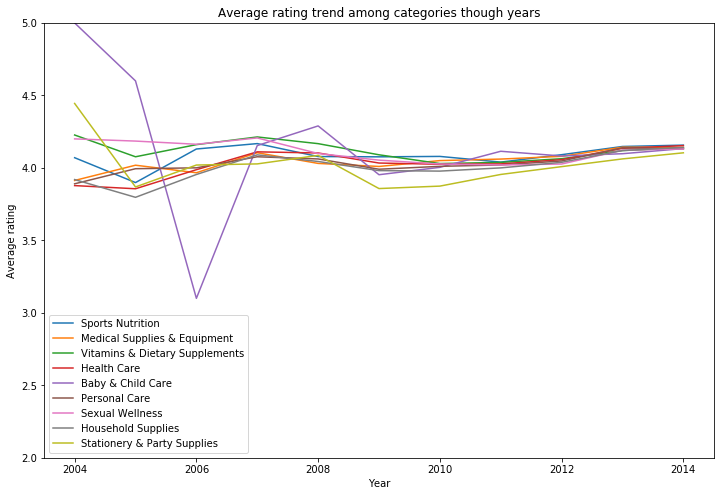

In [42]:
rating_average_trend(df_health_category,rating_avg.index.values.tolist())

⬆From above line plot, it shows:
1. That all cateroies change slightly but category 'Stationery & Party Supplies' have a different trend that its average rating drop to minimum at 2006 and start to fluctuate from 2007 t0 2014. 

#### 3.1.7 Review quantity trend  of interested categories trend through years

In [43]:
def review_quantity_trend(df, list_category_name):
    
    ''''
       Plot the review quantity trend between 2004-2014 for selected categories
       
       Parameter: 
       df : a dataframe
       list_category_name : a list of category names'''
    
    _, ax1 = plt.subplots(figsize = (12,8))
    
    for cat_name in list_category_name:
        intersted_category = df[df['2nd'] == cat_name]
        inter = intersted_category.groupby(intersted_category.time.dt.year)[['overall']].count()
        inter = inter.loc[inter.index>2003]
        inter.index = inter.index.astype('int')
        inter.loc[inter.index>2003].plot(ax=ax1)
    
    ax1.legend(list_category_name)
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Review quantity ')
    plt.title('Review quantity trend among categories through years')
    plt.show()

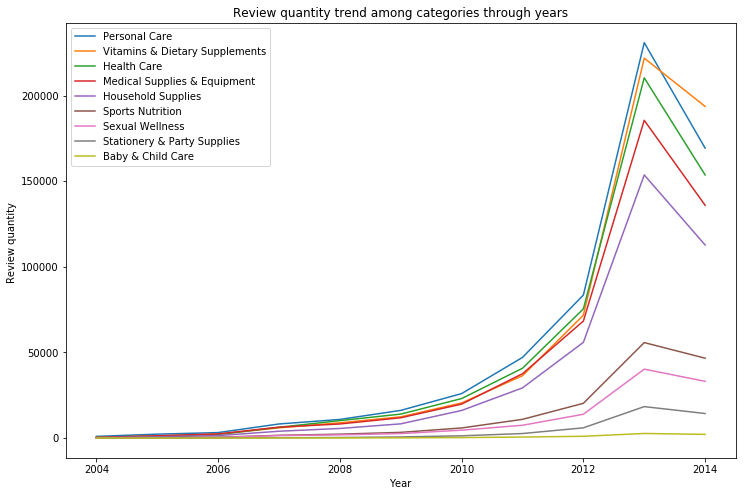

In [44]:
review_quantity_trend(df_health_category,review_quantity.index.values.tolist())

⬆From the figure above , we know that:
1. All catories have a same increasing trend. Their review quantity increase from 2004 to 2010 and after 2014, it grows very fast. 
2. As for the reason for the drop in 2013-2014, it is that the health review dataset does not include the whole year review and only records data in several months.

### 2.4 Correlation analysis

- To some extent, the review quantity can reflect popularity of the product among people and to what extent people are concerned about health product nowadays. In this part, we analyze the **correlation between review quantity and price** and the **correlation between review quantity and SalesRank** to see whether the price and SalesRank have a linear impact on review quantity.  

In [45]:
# Take the 'price' data from meta
df_health_meta = health_care_meta.copy()
df_health_meta_price = df_health_meta.loc[df_health_meta['price']!=0][['price']]
# Create a new DataFrame for review quantity and price 
df_health_review_count = df_health_review.groupby('asin').count()
df_health_review_count = df_health_review_count.iloc[:, [0]]
df_health_review_count.columns = ['review_count']
df_health_count_price = pd.merge(df_health_meta_price, df_health_review_count, left_index=True, right_index=True)

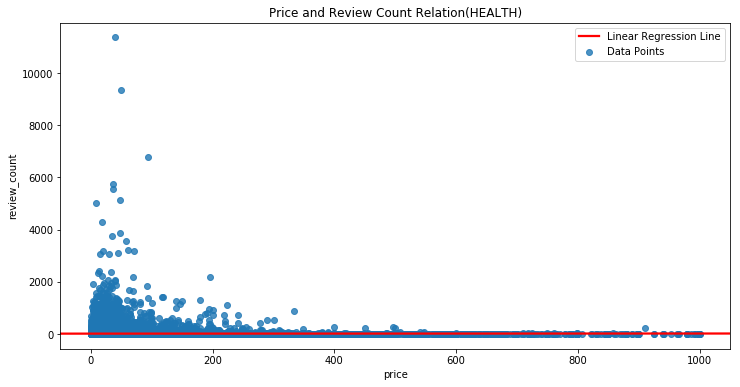

In [46]:
# Plot the scatter figure to see the relationship
plt.figure(figsize=(12, 6))
sns.regplot('price', 'review_count', data=df_health_count_price, line_kws={'color':'r'})
plt.title('Price and Review Count Relation(HEALTH)')
plt.legend(('Linear Regression Line', 'Data Points'))
plt.show()

In [47]:
# Compute the pearson correlation between price and review quantity
pearson_corr_health = df_health_count_price.corr()
pearson_corr_health

,price,review_count
price,1.000000,0.002674
review_count,0.002674,1.000000


⬆From the figure and correlation matrix above, we know that:
1. Health and Personal Care product with lower price has a higher review quantity, which means cheaper Health and Personal Care product are more popular among people and people are not willing to buy health product very expensive.
2. The correlation between price and review quantity is only 0.002674 and linear regression line can not fit the whole data at all, which means price and review quantity have a very bad linear relationship.

In [48]:
# Create a new DataFrame for review quantity and salesRank 
df_health_meta_salesRank_health = health_valid_salerank[['salesRank']]
df_health_meta_salesRank_health = pd.DataFrame(df_health_meta_salesRank_health.salesRank.map(lambda x: x['Health & Personal Care']))
df_count_rank_health = pd.merge(df_health_meta_salesRank_health, df_health_review_count, left_index=True, right_index=True)

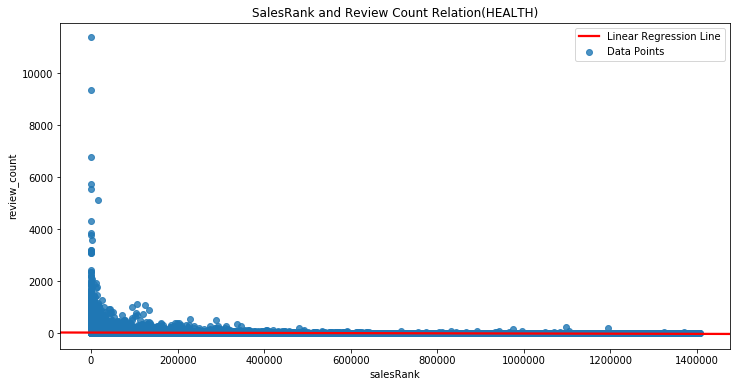

In [49]:
# Plot the scatter figure to see the relationship
plt.figure(figsize=(12, 6))
sns.regplot('salesRank', 'review_count', data=df_count_rank_health, line_kws={'color':'r'})
plt.title('SalesRank and Review Count Relation(HEALTH)')
plt.legend(('Linear Regression Line', 'Data Points'))
plt.show()

In [50]:
# Compute the pearson correlation between price and review quantity
pearson_corr_health = df_count_rank_health.corr()
pearson_corr_health

,salesRank,review_count
salesRank,1.00000,-0.14066
review_count,-0.14066,1.00000


⬆From the figure and correlation matrix above, we know that:
1. Health and Personal Care product with higher salesRank has a higher review quantity, which means people tend to buy Health and Personal Care product that is widely used and has been bought by a lot of other consumers.
2. The correlation between salesRank and review quantity is only -0.14066 and linear regression line also can not fit the whole data well, which means salesRank and review quantity do not have a good linear relationship.

## 3. Key Words Anylisis of Review

**Defination of [key words](https://en.wikipedia.org/wiki/Keyword_(linguistics) of Review:**

>Keyness is the quality a word has of being "key" in its context. A word has keyness in a certain textual context can be called a key word. 

In general, key words of review are words in review which typically describe some particular topics of the review. In this project, we extract key words of reviews in two ways.

In [3]:
# Constant parameter
Seed = 0

In [4]:
# Prepare the data
df_health_review = pd.read_pickle(DATA_FOLDER + REVIEWS_HEALTH_CARE)
reviews = df_health_review[['asin', 'reviewText']]
reviews['ReviewTime'] = df_health_review['ReviewTime'].map(lambda x: x.year)
reviews.head(5)

,asin,reviewText,ReviewTime
0,0077614992,This book was a requirement for a college clas...,2013
1,0615208479,This is a great gift for anyone who wants to h...,2008
2,0615269990,Very helpful in learning about different disea...,2014
3,0615269990,Occam's Razor is an unbelievably intuitive and...,2013
4,0615269990,I met the guys from Nerdcore at a medical conf...,2014


### 3.1 Extract key words according to POS frequency

>In corpus linguistics, a [key word](https://en.wikipedia.org/wiki/Keyword_(linguistics) is a word which occurs in a text more often than we would expect to occur by chance alone.

Intuitively, the frequency of words in a review can represent the keyness of words to some extent. However, some very frequent small words([Stop word](https://en.wikipedia.org/wiki/Stop_words)) carry little information and can drown out information contained in real content words.
<br>

Parts-of-speech are categories of words that exhibit similar grammatical properties such as adjectives, adverbs and verbs. To avoid negative effect of stop words, we focus on the frequency of nouns, adjectives, adverbs and verbs in reviews. To be able to identify the Parts-of-speech of word that we will need for our analysis, we use [Spacy](https://spacy.io/usage/) package for Python. Spacy is capable of returning PoS tags for any given word. 


**Method**:<br>
We are going to find nouns, verbs, adverbs, and adjectives in reveiws of **health care products** of **each year**.
- Group reviews by year and focus reviews of each year.
2. Tokenization: Maps reviews into sequence of tokens.
3. Lemmatization: Transform all forms of words into original form, e.g. transform 'went' and 'goes' into 'go' using `.lemma_` attribute of tokens.
4. Select only nouns, verbs, adverbs, and adjectives using `.pos_` attribute of tokens.

In [5]:
def get_POS(reviews):
    '''
        Get nouns, adjectives, adverbs and verbs in reviews of each year.
    '''
    # Load general stop words in Spacy package
    STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
    keywords_year_dict = {}
    # Consider POS of reviews of each year
    grouped_year = reviews.groupby('ReviewTime')
    for name, group in grouped_year:
        nouns = []
        verbs = []
        advs = []
        adjs = []
        for doc in group.reviewText:
            # Tokenization
            doc = nlp(doc)
            # Distract NOUN, VERB, ADV, ADJ of reviews and turn their lemmas
            for token in doc:
                # Removing stop words, like 'my','I',etc
                if not token.is_stop and token.text not in STOPWORDS:
                    if token.pos_ == "NOUN":
                        nouns.append(token.lemma_)
                    if token.pos_ == "VERB":
                        verbs.append(token.lemma_)
                    if token.pos_ == "ADV":
                        advs.append(token.lemma_)
                    if token.pos_ == "ADJ":
                        adjs.append(token.lemma_)
        # Zip POS of reviews of each year in a dictionary
        keywords_year_dict.update({str(name):{"NOUN":nouns, "VERB": verbs, "ADV": advs, "ADJ": adjs}})
    return keywords_year_dict

In [6]:
# ---------- get POS of reviews of each year and save ---------- #
# keywords_year_dict = get_POS(reviews.sample(frac=0.1, random_state=Seed))
# with open('keywords_year_dict.pickle', 'wb') as handle:
#     pickle.dump(keywords_year_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(DATA_FOLDER + 'keywords_year_dict.pickle', 'rb') as handle:
    keywords_year_dict = pickle.load(handle)

**Visualization:**

A [word cloud](https://en.wikipedia.org/wiki/Tag_cloud) is a visual representation of text data, typically used to depict keyword metadata (tags) on websites, or to visualize free form text.We use `WordCloud` function from [**wordcloud**](https://amueller.github.io/word_cloud/index.html) package to draw wordcloud for each year.

We firstly plot data of year 2013 as an example, then analyze each year in detail.

In [7]:
def draw_wordcloud(keyword_list, stopword, mask, top_word_num = 10):
    '''
        Draw the wordcloud of key words and legend top words in them.
    '''
    # Create wordcloud 
    wordcloud = WordCloud(background_color='white',
                          mask=mask,
                          collocations=False, 
                          stopwords=stopword, 
#                           colormap="Set2_r",
                          max_words=1000,
                          max_font_size=200).generate(" ".join(keyword_list))
    plt.imshow(wordcloud)
    # Set legend option and put a legend to the right of the current axis
    colors = []
    words = []
    for element in wordcloud.layout_[0:top_word_num]:
        ((word,freq),size,pos,orientation,color) = element
        color = tuple(map(lambda x:int(x)/255, color.strip('rgb(').strip(')').split(',')))
        colors.append(color)
        words.append(word)
    patches = []
    for i in range(top_word_num):
        patches.append(mpatches.Patch(color=colors[i], label=words[i]))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),handles=patches)
    
    plt.axis("off")

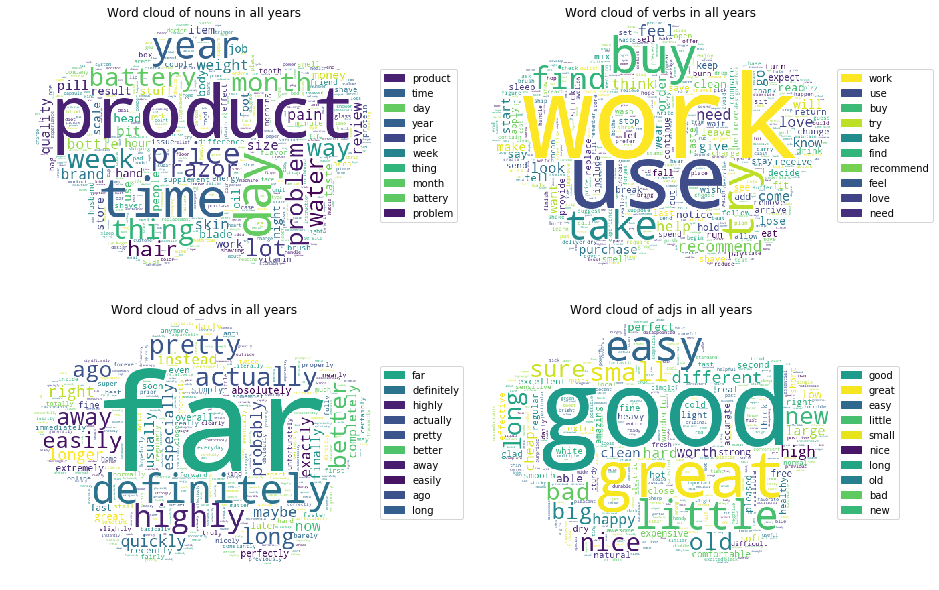

In [10]:
# Key words of all years
top_word_num = 10
# Filiter '-PRON-' in POS of reviews
del_word = ['PRON']
stopword = STOPWORDS|set(del_word)
picture = imageio.imread('mask-cloud.png')

POS_LIST = ['NOUN', 'VERB', 'ADV', 'ADJ']
fig = plt.figure(figsize=(15,10))
for i, POS in enumerate(POS_LIST):
    plt.subplot(2, 2, i+1)
    keyword_all_year = []
    for j in keywords_year_dict.keys():
        keyword_all_year.extend(keywords_year_dict[j][POS])
    draw_wordcloud(keyword_all_year, stopword, picture, top_word_num)
    plt.title('Word cloud of ' + POS.lower() + 's in all years')
plt.show()

⬆From the figures above, we know that:
1. Top words in nouns are words that describe common attributes of all kinds of products such as 'product', 'price', 'time', which do not offer any explicit aspect of health care products. So as verbs, which are not very informative. 
2. We can see that in key words of all years, positive words such as 'good', 'great', 'easy', 'nice' have a high probability in adjectives. Although negative words such as 'bad', 'old' also occupy a high probability, they are obviously lower than positive words. Roughly, it means reviews on health care products in these years are mainly positive.

--------------

### 3.2 Key Words Changing Over Year

Adjectives alone are a good and imformative way of quickly extracting an impression on a product. So we use ajectives to represent the changing of key words over years.

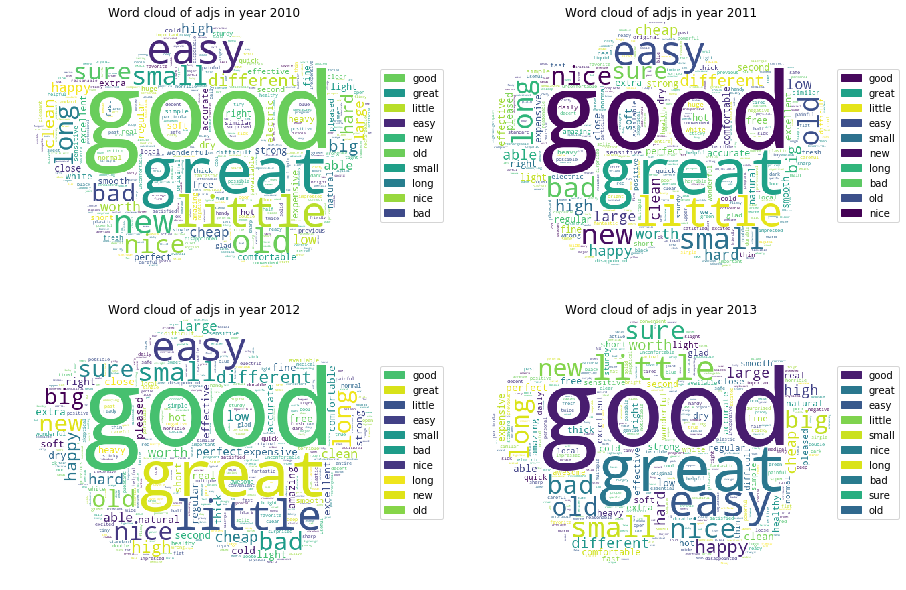

In [11]:
# We use ajectives to represent the changing of key words over years.
Year_LIST = ['2010', '2011', '2012', '2013']
fig = plt.figure(figsize=(15,10))
for i, year in enumerate(Year_LIST):
    plt.subplot(2, 2, i+1)
    keyword_list = keywords_year_dict[year]['ADJ']
    draw_wordcloud(keyword_list, stopword, picture, top_word_num)
    plt.title('Word cloud of adjs in year ' + year)
plt.show()

⬆From the figures above, we can know that:
1. From year 2008 to 2013, the top10 key words of health care products in adjectives remain quite stable, which are 'good', 'great', 'little', 'easy', 'new', 'old', 'small', 'long', 'nice', 'bad' but in different order (relative frequency) in different years.
2. The key words 'good' and 'great' are dominant in every year which have a much higher probability than word 'bad'. To some extent, we can make a conclusion that the key words of health care products change slightly and always have a relatively positive evaluation in these years.

--------------

### 3.3 Analyze collocations of words

- Sometimes single word can not describe attributes of product explicitly. For example, suppose that we receive multiple times the adjective 'good', we are not sure what exactly is considered by the users as good in this product. Is it the price or its performances? We therefore also want to analyze **collocations of words**.

**Method**:<br>
- Tokenize reviews, Lemmatize tokens and remove stop words.
- Use `gensim.models.phrases` module in [gensim](https://radimrehurek.com/gensim/) library to get collocations (big of word) of words.  

In [12]:
def get_bigram(docs, min_count):
    '''
        Add bigrams to docs (only ones that appear min_count times or more).
    '''
    bigram_list = []
    bigram = Phrases(docs, min_count)
    for idx in range(len(docs)):
        bigram_word = []
        for token in bigram[docs[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                bigram_word.append(token)
        bigram_list.append(bigram_word)
    return bigram_list

In [13]:
def analyze_bigram(reviews):
    docs_year_dict = {}
    # A set of stopwords
    STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
    grouped_year = reviews.groupby('ReviewTime')
    for name, group in grouped_year:
        # Put all reviews in a year to a list
        docs = []
        for review in group.reviewText:
            # NLP analyze and get a Spacy object
            doc = nlp(review)
            # Lemmatize tokens, Keep only words and remove stopwords.
            doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
            # Remove common words from a stopword list and keep only words of length 3 or more.
            doc = [token for token in doc if token not in STOPWORDS and len(token) > 2]
            docs.append(doc)
        # get bigrams to docs (only ones that appear 2 times or more).
        docs = get_bigram(docs, 2)
        extend_docs = []
        for bigram_word in docs:
            extend_docs.extend(bigram_word)
        docs_year_dict.update({str(name):extend_docs})   
    return docs_year_dict

In [14]:
# bigram_year_dict = analyze_bigram(reviews.sample(frac=0.1, random_state=Seed))
# # ---------- get data and save ---------- #
# with open('bigram_year_dict.pickle', 'wb') as handle:
#     pickle.dump(bigram_year_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(DATA_FOLDER + 'bigram_year_dict.pickle', 'rb') as handle:
    bigram_year_dict = pickle.load(handle)

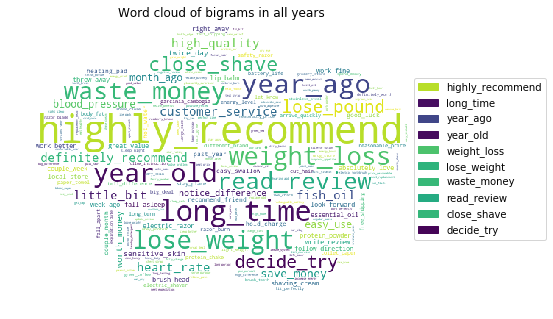

In [15]:
# Word cloud of bigrams in all years
fig = plt.figure(figsize=(16,5))
keyword_all_year = []
for i in bigram_year_dict.keys():
    keyword_all_year.extend(bigram_year_dict[i])
draw_wordcloud(keyword_all_year, stopword, picture, top_word_num)
plt.title('Word cloud of bigrams in all years')
plt.show()

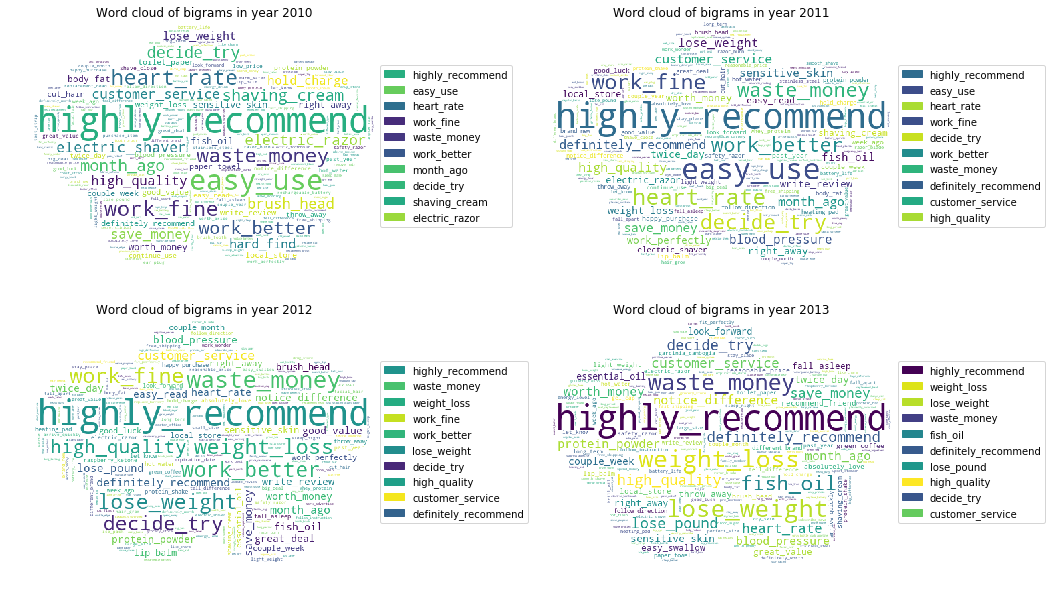

In [21]:
del_word = ['long_time', 'year_ago', 'year_old', 'little_bit', 'close_shave', 'read_review']
stopword = STOPWORDS|set(del_word)
picture = imageio.imread('mask-cloud.png')
top_word_num = 10
# Plot bigrams over years
Year_LIST = ['2010', '2011', '2012', '2013']
fig = plt.figure(figsize=(17,10))
for i, year in enumerate(Year_LIST):
    plt.subplot(2, 2, i+1)
    keyword_list = bigram_year_dict[year]
    draw_wordcloud(keyword_list, stopword, picture, top_word_num)
    plt.title('Word cloud of bigrams in year ' + year)
plt.savefig('keyword_all_year.png')
plt.show()

⬆From the figures above, we can know that:
1. If we foucs on bigrams in reviews, we get a outcome quite different from that we get when we only analyze a single part-of-speech above(e.g. adjectives). We find that the words with high probability in adjectives like 'good', 'great' almost disappear, and bigrams with 'adj-noun' structure occur much less than those with 'adv-verb', 'noun-noun' structures.
2. From 2008 to 2013, **'highly recommend'** always has the highest frequency among all bigrams and it can naturally be regarded as a positive bigram. Although negative bigram like **'waste money'** also has a top 10 probability in bigrams, its probability is much lower. So, roughly, we can say that health care products always have a positive evaluation in general and keep popular over these year.
3. We find a interesting phenomenon that **'heart rate'** occurs frequently from 2008 to 2011, however, it disappears from top 10 key bigrams after 2012. At the same time, **'lose weight'** gets more popular and becomes a top 10 key bigram after 2012. From this phenomenon, we may find that people pay more attention to their appearance than before, they are more willing to buy health care products to build a slim figure.

--------------

In [14]:
def interested_day(df,month,day):
    # a week
    df['month-day'] = df['ReviewTime'].apply(lambda x: x.strftime('%m-%d'))
    date = datetime.datetime.strptime(str(month)+'-'+str(day),"%m-%d")
    delta = datetime.timedelta(days=7)
    
    date_period = (date+delta).strftime('%m-%d')
    date_period_month = (date+delta).strftime('%m')
    date_start  = date.strftime('%m-%d')
    date_start_month  = date.strftime('%m')
    
    
    if date_start_month <= date_period_month:
        interested_day = df[(df['month-day']<date_period)&(df['month-day']>=date_start)]
    else:
        interested_day = df[((df['month-day']>=date_start))&(df['month-day']<='12-31')|(df['month-day']<date_period)]
    return interested_day

In [16]:
interest_day = interested_day(df_health_review, 12, 25)

In [19]:
interest_day.reviewText.iloc[0:10]

19     Started using electric cord at home and within...
96     I love this thing.  I gave it 4 stars because ...
98     Susan has a realistic way of bringing optimism...
103    You know, dropping $73 for this book was not s...
209    These gift tags are very pretty but it would b...
210    Cavallini never disappoints me. I love their p...
219    It does not  lay flat........its looks cheap.....
235    These remind me of the vintage cards I got as ...
320    This paper tape set is one of my favorites. I ...
338    cards were very cute, same with tin and sticke...
Name: reviewText, dtype: object

In [26]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
keywords_christmas_dict = {}
nouns = []
verbs = []
advs = []
adjs = []
for doc in interest_day.reviewText:
    # Tokenization
    doc = nlp(doc)
    # Distract NOUN, VERB, ADV, ADJ of reviews and turn their lemmas
    for token in doc:
        # Removing stop words, like 'my','I',etc
        if not token.is_stop and token.text not in STOPWORDS:
            if token.pos_ == "NOUN":
                nouns.append(token.lemma_)
            if token.pos_ == "VERB":
                verbs.append(token.lemma_)
            if token.pos_ == "ADV":
                advs.append(token.lemma_)
            if token.pos_ == "ADJ":
                adjs.append(token.lemma_)
keywords_christmas_dict.update({"NOUN":nouns, "VERB": verbs, "ADV": advs, "ADJ": adjs})
keywords_christmas_dict

{'NOUN': ['cord',
  'home',
  'month',
  'base',
  'cord',
  'clip',
  'light',
  'part',
  'light',
  'thing',
  'star',
  'way',
  'paper',
  'thing',
  'way',
  'optimism',
  'table',
  'part',
  'cancer',
  'cancer',
  'choice',
  'book',
  'perspective',
  'idea',
  'battle',
  'cancer',
  'life',
  'moment',
  'thing',
  'victor',
  'life',
  'happiness',
  'situation',
  'wisdom',
  'undercurrent',
  'smile',
  'book',
  'e',
  'book',
  'appeal',
  'version',
  'quality',
  'paper',
  'chemical',
  'diagram',
  'notation',
  'reason',
  'hardcover--',
  'bc',
  'hardcover',
  'quality',
  'book',
  'quality',
  'dollar',
  'book',
  'today',
  'paper',
  'quality',
  'phone',
  'book',
  'garbage',
  'computer',
  'paper',
  '100x',
  'quality',
  'newspaper',
  'horrid',
  'deal',
  'cover',
  'note',
  'margin',
  'diagram',
  'none',
  'page',
  'quality',
  'newspaper',
  'hamster',
  'cage',
  'day',
  'ploy',
  'people',
  'page',
  'them--',
  'geniuses--',
  'trouble',


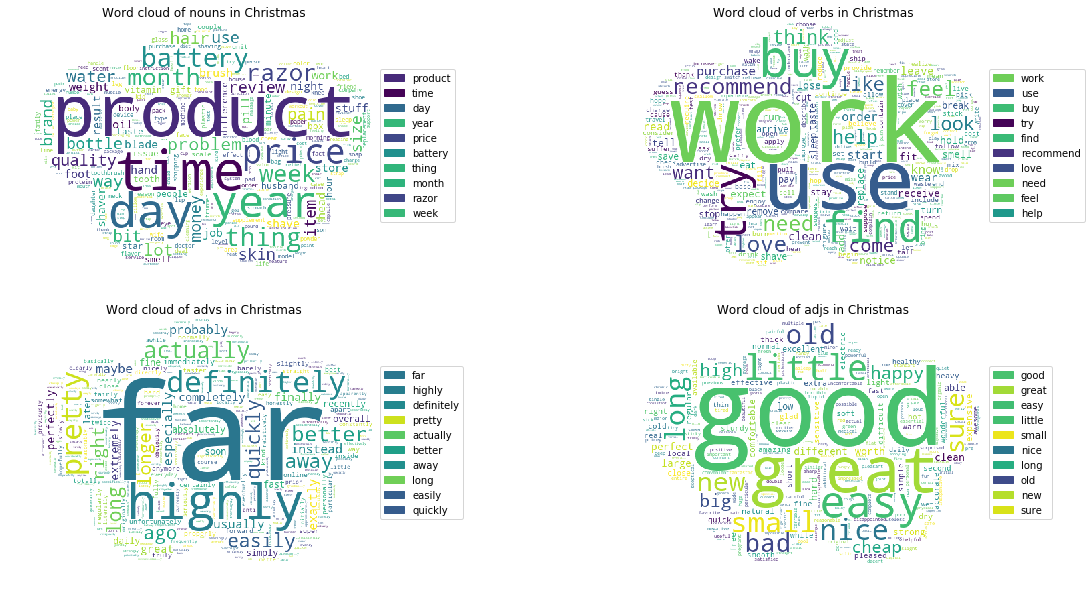

In [31]:
# Key words of all years
top_word_num = 10
# Filiter '-PRON-' in POS of reviews
del_word = ['PRON']
stopword = STOPWORDS|set(del_word)
picture = imageio.imread('mask-cloud.png')

POS_LIST = ['NOUN', 'VERB', 'ADV', 'ADJ']
fig = plt.figure(figsize=(20,10))
for i, POS in enumerate(POS_LIST):
    plt.subplot(2, 2, i+1)
    draw_wordcloud(keywords_christmas_dict[POS], stopword, picture, top_word_num)
    plt.title('Word cloud of ' + POS.lower() + 's in Christmas')
plt.show()

In [27]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
bigrams_christmas_dict = {}
docs = []
for doc in interest_day.reviewText:
    # Tokenization
    doc = nlp(doc)
    # Lemmatize tokens, Keep only words and remove stopwords.
    doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    # Remove common words from a stopword list and keep only words of length 3 or more.
    doc = [token for token in doc if token not in STOPWORDS and len(token) > 2]
    docs.append(doc)
# get bigrams to docs (only ones that appear 2 times or more).
docs = get_bigram(docs, 2)
extend_docs = []
for bigram_word in docs:
    extend_docs.extend(bigram_word)
extend_docs

['electric_cord',
 'vertical_horizontal',
 'super_excited',
 'cancer_cancer',
 'high_quality',
 'big_deal',
 'read_book',
 'shame_amazon',
 'gift_tag',
 'recipient_love',
 'lie_flat',
 'add_bonus',
 'highly_recommend',
 'lay_flat',
 'tuck_away',
 'work_wonderfully',
 'gift_card',
 'non_pharmaceutical',
 'sleep_aid',
 'read_review',
 'agree_reviewer',
 'relatively_quickly',
 'star_rating',
 'healing_process',
 'highly_recommend',
 'pharmacy_carry',
 'fall_apart',
 'sore_muscle',
 'arthritic_pain',
 'temporary_relief',
 'joint_ache',
 'highly_recomm',
 'year_old',
 'grand_daughter',
 'like_charm',
 'worth_effort',
 'value_money',
 'ship_quickly',
 'fraction_price',
 'enjoy_herbalife',
 'burn_fat',
 'young_child',
 'share_friend',
 'absolutely_love',
 'compare_similar',
 'battery_life',
 'rechargeable_battery',
 'wal_mart',
 'old_nicd',
 'work_fine',
 'recent_trip',
 'afternoon_evening',
 'rechargeable_battery',
 'recharge_battery',
 'hold_charge',
 'set_aside',
 'nimh_battery',
 'sanyo_e

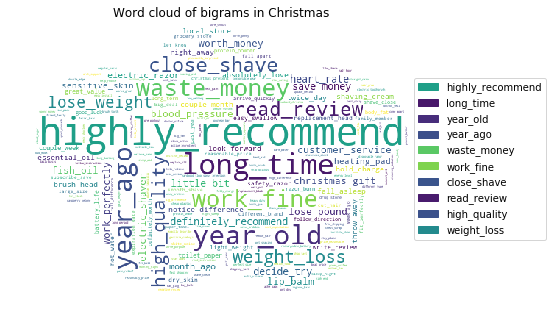

In [33]:
fig = plt.figure(figsize=(16,5))
top_word_num = 10
draw_wordcloud(extend_docs, stopword, picture, top_word_num)
plt.title('Word cloud of bigrams in Christmas')
plt.show()

**2.4 Recommend a category (second category) of Health care products**

We are going to recommend a category (second category) of Health care products according to the **need (product description)** of the consumer. We create a bag of word and apply supervised (SVM) machine learning method to realize this recommendation function.

**Method**:<br>
- Tokenize reviews, lemmatize tokens. Keep only words and remove stop words.
- Create the bag of word of all reviews, turn each review to a word vector and use a sparse matrix to store the word vectors of all reviews. Label each review according to their second category.
- Use SVM machine learning method to train a multi-classification model.
- Give consumer's need (product description), classify it to one class and then recommend this category of health care product to consumer.

In [18]:
# Parpare data: split the category into several sub-categories
df_health_merge_review = pd.read_pickle(DATA_FOLDER + HEALTH_CARE)

health_category = df_health_merge_review.categories.apply(lambda x : x[0]).values.tolist()
df_health_category = pd.DataFrame(health_category)
df_health_category.columns = ['1st','2nd','3rd','4th','5th','6th','7th']

df_health_category['asin'] = df_health_merge_review.asin
df_health_category['overall'] = df_health_merge_review.overall
df_health_category['ReviewTime'] = df_health_merge_review.ReviewTime
df_health_category['reviewText'] = df_health_merge_review.reviewText
df_health_category['title'] = df_health_merge_review.title
df_health_category.drop(columns=['3rd','4th','5th','6th','7th'], inplace=True)
df_health_category.head()

,1st,2nd,asin,overall,ReviewTime,reviewText,title
0,Health & Personal Care,None,0077614992,5.0,2013-02-15,This book was a requirement for a college clas...,Principles of Mgmt + Oper-CSUF Custom C
1,Health & Personal Care,Personal Care,0615208479,5.0,2008-12-01,This is a great gift for anyone who wants to h...,Brain Fitness Exercises Software
2,Health & Personal Care,Personal Care,0615269990,5.0,2014-04-06,Very helpful in learning about different disea...,Occam's Razor
3,Health & Personal Care,Personal Care,0615269990,5.0,2013-12-04,Occam's Razor is an unbelievably intuitive and...,Occam's Razor
4,Health & Personal Care,Personal Care,0615269990,2.0,2014-04-24,I met the guys from Nerdcore at a medical conf...,Occam's Razor


In [8]:
def get_bag_of_word(reviews):
    # A set of stopwords
    STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
    # Group reviews by 2nd category
    grouped_asin = reviews.groupby('2nd')
    docs = []
    Y = []
    for i, (asin, group) in enumerate(grouped_asin):
        # Put all reviews in one category to a list
        for review in group.reviewText:
            # NLP analyze and get a Spacy object
            doc = nlp(str(review))
            # Lemmatize tokens, Keep only words and remove stopwords.
            doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
            # Remove common words from a stopword list and keep only words of length 3 or more.
            doc = [token for token in doc if token not in STOPWORDS and len(token) > 2]
            doc = " ".join(doc)
            docs.append(doc)
            Y.append(i)
    # Create bag of words features
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(docs)
    return X, Y

In [5]:
# X, Y = get_bag_of_word(df_health_category.sample(frac=0.1, random_state=Seed))
# # ---------- get data and save ---------- #
# with open('SVM_X.pickle', 'wb') as handle:
#     pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('SVM_Y.pickle', 'wb') as handle:
#     pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('SVM_X.pickle', 'rb') as handle:
    X = pickle.load(handle)
with open('SVM_Y.pickle', 'rb') as handle:
    Y = pickle.load(handle)

In [6]:
# Construct sklearn pipe line to process data
def svm_classification(X, Y):
    # TF-idf
    transformer = TfidfTransformer(smooth_idf=False)
    X = transformer.fit_transform(X)
    #shuffle the data
    X, Y = shuffle(X, Y, random_state=0)
    #split into training and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
    clf = svm.SVC(gamma=0.0001)
    clf.fit(X_train, Y_train)
#     scores = cross_val_score(clf, X_train,Y_train, cv=10)
#     print(scores)
    return clf.score(X_test, Y_test)

In [ ]:
svm_classification(X, Y)

In [11]:
X, Y = get_bag_of_word(df_health_category.iloc[0:100])
svm_classification(X, Y)

0.6666666666666666

--------------

In [204]:
# Create a new DataFrame for review time and the number of reveiw 
df_reviewtime_reveiwnum = df_health_review.groupby('ReviewTime').count()[['asin']]
df_reviewtime_reveiwnum.columns = ['ReviewNumber']
df_reviewtime_reveiwnum = df_reviewtime_reveiwnum.reset_index()

In [205]:
flag = df_reviewtime_reveiwnum['ReviewTime'].map(lambda x: (x.year>2003)&((x.year<2014)))
df_reviewtime_reveiwnum_subset = df_reviewtime_reveiwnum.loc[flag]
df_reviewtime_reveiwnum_subset.head()

,ReviewTime,ReviewNumber
832,2004-01-01,14
833,2004-01-02,6
834,2004-01-03,5
835,2004-01-04,10
836,2004-01-05,14


In [206]:
def plot_seasonal_decomposition(df_reviewtime_reveiwnum_subset, seasonal_decomposition_list, title_list, ylabel_list):
    '''
         Plot seasonal decomposition figures: 
         Initial Time Series Figure, Trend Component Figure, Seasonal Component Figure.
    '''
    for i in range(3):
        plt.subplot(3,1,i + 1)
        plt.plot(df_reviewtime_reveiwnum_subset.ReviewTime, seasonal_decomposition_list[i])
        plt.xlabel('Date')
        plt.ylabel(ylabel_list[i])
        plt.title(title_list[i])
        plt.legend(['Data Change Line'])
    plt.show()

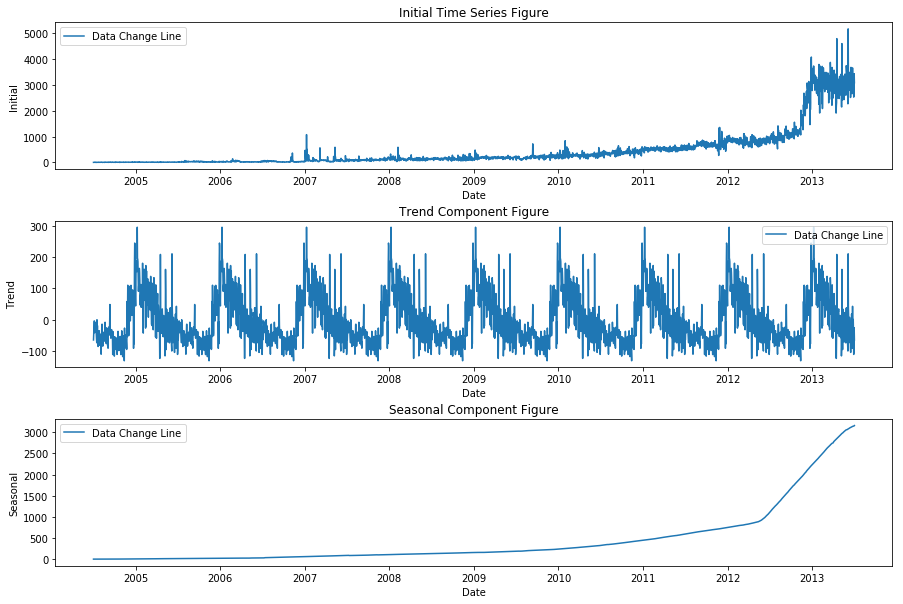

In [220]:
seasonal_decomposition = seasonal_decompose(df_reviewtime_reveiwnum_subset.ReviewNumber,freq=365)

# ---------- Prepare the input data ---------- #
not_null_index = seasonal_decomposition.trend.isnull().map(lambda x: not x)
# Drop null data in seasonal decomposition
observed_data = seasonal_decomposition.observed[not_null_index]
seasonal_data = seasonal_decomposition.seasonal[not_null_index]
trend_data = seasonal_decomposition.trend[not_null_index]
resid_data = seasonal_decomposition.resid[not_null_index]
trend_time = df_reviewtime_reveiwnum_subset[not_null_index]

# ---------- Plot seasonal decomposition ---------- #
fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=0.35)
title_list = ['Initial Time Series Figure', 'Trend Component Figure', 'Seasonal Component Figure']
ylabel_list = ['Initial', 'Trend', 'Seasonal']
seasonal_decomposition_list = [observed_data, seasonal_data, trend_data, resid_data]
plot_seasonal_decomposition(trend_time, seasonal_decomposition_list, title_list, ylabel_list)

⬆From the figures above, we know that:
1. There is a remarkable increasing trend of review number and the growth rate is becoming more and more faster with the years.
2. There exists a yearly seasonal trend, which starts to grow from November, reaches its peaks around January and then  drops to its lowest point around June.
3. We infer that the growth of review (consumption) is stimulated by Christmas. People may tend to buy more health care products and sent them to their friends or relatives as gifts, which significantly boost the consumption. While after Christmas, the need of health care products gradually falls back.

**Predict trend of review quantity (popularity)**

The review quantity can reflect popularity of the products. From `Initial Time Series Figure` above, we can easily know the changing of review quantity over time. According to the review data we already have, we hope to give a prediction of the future review quantity, namely the trend of popularity of health care products.

**Method**:<br>
- Use `sklearn.preprocessing.PolynomialFeatures` function to generate a new feature matrix consisting of all polynomial combinations of the features(i.e. time).
- Use **ridge regression model** to perform a linear regession. Take 95% `trend` component data as training set to fit the model and tune hyperparameter by cross-validation. Use the left 5% data as test set to test the performance of the model.
- Predict feture trend in one year (2013-7-2 to 2014-7-2). Adding `seasonal` component and combining `residual` component, we can predict a range of review quantity over time.

In [228]:
trend_time_series = trend_time['ReviewTime']
time_timestamp = trend_time['ReviewTime'].map(lambda x: int(x.timestamp()))
# Polynomial combinations of the features
X = time_timestamp.values.reshape(-1,1) / 3600 / 24
poly = PolynomialFeatures(6)
X_poly = poly.fit_transform(X)
Y = trend_data.values.reshape(-1,1)
# Take 95% trend component data as training set, 5% as test set
X_train = X_poly[:int(0.95*X.shape[0])]
Y_train = Y[:int(0.95*Y.shape[0])]
X_test = X_poly[int(0.95*X.shape[0]):]
Y_test = Y[int(0.95*Y.shape[0]):]
# Fit the model and tune hyperparameter by cross-validation
reg = linear_model.RidgeCV(alphas=np.linspace(1,15,5000), cv=10)
reg.fit(X_train, Y_train)
# Use the test set to test the performance of the model
print('Coefficient of determination R^2 of the prediction:', reg.score(X_test, Y_test))
print('The value of hyperparameter alpha:', reg.alpha_)

Coefficient of determination R^2 of the prediction: 0.767588463569373
The value of hyperparameter alpha: 2.996799359871974


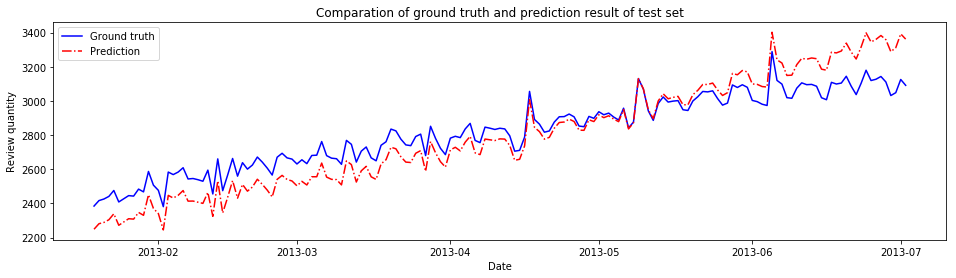

In [257]:
# Plot test result 
plt.figure(figsize=(16,4))
plt.plot(trend_time_series[int(0.95*X.shape[0]):], 
         observed_data[int(0.95*X.shape[0]):] - resid_data[int(0.95*X.shape[0]):], 
         'b-',
         trend_time_series[int(0.95*X.shape[0]):], 
         (reg.predict(X_test).squeeze() + seasonal_data.values[int(0.95*X.shape[0]):]), 
         'r-.')
plt.xlabel('Date')
plt.ylabel('Review quantity')
plt.title('Comparation of ground truth and prediction result of test set')
plt.legend(['Ground truth', 'Prediction'])
plt.show()

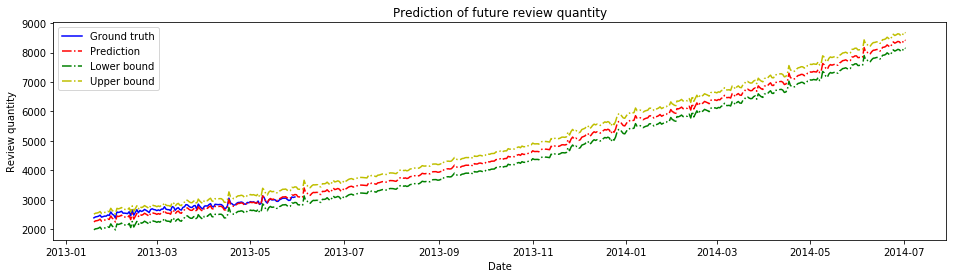

In [258]:
# Predict feture trend in one year (2013-7-2 to 2014-7-2)
last_day = trend_time_series[int(0.95*X.shape[0]):].iloc[-1]
time_predict = np.array([last_day + pd.to_timedelta(i,unit="D") for i in range(1, 366)])
time_exist = np.array(list(map(lambda x: pd.to_datetime(x), trend_time_series[int(0.95*X.shape[0]):].values)))
time_whole = np.concatenate((time_exist, time_predict), axis = 0)

time_whole_X = pd.Series(time_whole)
time_whole_X = time_whole_X.map(lambda x: int(x.timestamp()))
time_whole_X = time_whole_X.values.reshape(-1,1) / 3600 / 24
time_whole_X_poly = poly.fit_transform(time_whole_X)
# Use concepts in box plot, get upper and lower quartiles of residual component
d = resid_data.describe()
IQR = d['75%'] - d['25%']
low_error, high_error = (d['25%'] - 1.5 * IQR, d['75%'] + 1.5 * IQR)
# Set upper and lower quartiles as of residual component as bounds, we indict a region of future trend
upper_resid_bound = reg.predict(time_whole_X_poly).squeeze() + seasonal_data_predict + high_error
lower_resid_bound = reg.predict(time_whole_X_poly).squeeze() + seasonal_data_predict + low_error
# Plot prediction result
plt.figure(figsize=(16,4))
time_exist = np.array(list(map(lambda x: pd.to_datetime(x), trend_time_series[int(0.95*X.shape[0]):int(0.99*X.shape[0])].values)))
seasonal_data_predict = np.concatenate((seasonal_data.values[int(0.95*X.shape[0]):], seasonal_data[-365:]))
plt.plot(time_exist, observed_data[int(0.95*X.shape[0]):int(0.99*X.shape[0])] - resid_data[int(0.95*X.shape[0]):int(0.99*X.shape[0])], 'b')
plt.plot(time_whole, (reg.predict(time_whole_X_poly).squeeze() + seasonal_data_predict), 'r-.')

# Plot bounds
plt.plot(time_whole, lower_resid_bound, 'g-.')
plt.plot(time_whole, upper_resid_bound, 'y-.')

plt.xlabel('Date')
plt.ylabel('Review quantity')
plt.title('Prediction of future review quantity')
plt.legend(['Ground truth', 'Prediction', 'Lower bound', 'Upper bound'])
plt.show()

⬆From the figure above, we can predict that:
1. The review quantity will significantly increase in one year.
2. The review quantity will fluctuate around `Prediction` line and be bounded in `Upper bound` and `Lower bound` lines. 

--------------

## 4.Review Sentiment Analysis

## Sentiment Analysis and Normalization

We use compound score to define whether the review is positive, neutral or negative. According to difinition:
- positive: compound score > 0.05
- neutral: -0.05 < compound score < 0.05
- negative:compound score < -0.05

In [ ]:
# Read product information in Health care including reviews
df_health_care = pd.read_pickle(DATA_FOLDER+ HEALTH_CARE)

df_product_review = df_health_care[["asin","title","reviewText","ReviewTime","categories","overall"]]

analyzer = SentimentIntensityAnalyzer()
df_product_review['reviewScore'] = df_product_review['reviewText'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
df_product_review['reviewScoreNorm'] = df_product_review[['reviewScore']] * 2 + 3

df_product_review.head()

In [ ]:
# save as pickle
df_product_review.to_pickle(DATA_FOLDER + PRODUCT_REVIEW_INFO)

## Sentiment Distribution Analysis

### Total

In this part, we mainly analysis the sentiment score for total products by their ```distribution``` and ```proportion``` of different sentiment occupied in the whole reviews. In addition, the ```extent``` of each sentiment are also provided inside.

In [4]:
# read from pickle
df_product_review = pd.read_pickle(DATA_FOLDER + PRODUCT_REVIEW_INFO)

Plot the distribution of total reviews' sentiment score

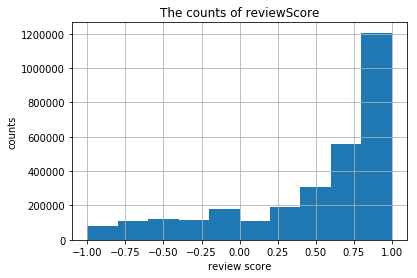

In [16]:
# plot distribution for total
df_product_review["reviewScore"].hist(bins=10)
plt.xlabel("review score")
plt.ylabel("counts")
plt.title("The counts of reviewScore")
plt.show()

⬆ What we can see above is that:
1. very large number of reviews are positive and most of them are close to extremely postive with socre higher than 0.75. 
2. The number of both negative reviews and neutral reviews are much more lower than the positive ones.

Print out the proportion for each sentiment.

In [17]:
pos_num = len(df_product_review[df_product_review["reviewScore"]>=0.05])
neu_num = len(df_product_review[(df_product_review["reviewScore"]>-0.05) & (df_product_review["reviewScore"]<0.05)])
neg_num = len(df_product_review[df_product_review["reviewScore"]<=-0.05])
total_num = len(df_product_review)

print("The number of positive reviews is :{pn} and occupies {p:.3f}% in the review".format(pn=pos_num,p=pos_num*100/total_num))
print("The number of neutral reviews is :{nu} and occupies {p:.3f}% in the review".format(nu=neu_num,p=neu_num*100/total_num))
print("The number of negative reviews is :{nu}and occupies {p:.3f}% in the review".format(nu=neg_num,p=neg_num*100/total_num))

The number of positive reviews is :2353432 and occupies 79.155% in the review
The number of neutral reviews is :124861 and occupies 4.200% in the review
The number of negative reviews is :494893and occupies 16.645% in the review


⬆ As is shown above: 
1. The positive reviews occupied the largest part in total (which is the same conclusion as we drew above) with about 79%, which means many people thinks the products in Health and Care are good. 
2. But for the negative part, there is also a remarkable percentage at about 16.6%, which means there are still lots of people consider that some products cannot satisfy their needs. 
3. Compared to other two kinds, the percentage of neutral reviews is quite smaller, which means most people have very clear attitude towards the products in this category.

Label each sentiment score with ```postive```,```negative```,```neutral``` for convinence.

In [18]:
df_product_review.loc[df_product_review["reviewScore"]>=0.05,"label"]="positive"
df_product_review.loc[(df_product_review["reviewScore"]>-0.05) & (df_product_review["reviewScore"]<0.05),"label"]="neutral"
df_product_review.loc[df_product_review["reviewScore"]<=-0.05,"label"]="negative"

In [19]:
df_product_review.head()

,asin,title,reviewText,ReviewTime,categories,reviewScore,overall,reviewScoreNorm,month-day,label
0,0077614992,Principles of Mgmt + Oper-CSUF Custom C,This book was a requirement for a college clas...,2013-02-15,[[Health & Personal Care]],0.2263,5,3.4526,02-15,positive
1,0615208479,Brain Fitness Exercises Software,This is a great gift for anyone who wants to h...,2008-12-01,"[[Health & Personal Care, Personal Care]]",0.9748,5,4.9496,12-01,positive
2,0615269990,Occam's Razor,Very helpful in learning about different disea...,2014-04-06,"[[Health & Personal Care, Personal Care, Shavi...",0.8313,5,4.6626,04-06,positive
3,0615269990,Occam's Razor,Occam's Razor is an unbelievably intuitive and...,2013-12-04,"[[Health & Personal Care, Personal Care, Shavi...",0.9984,5,4.9968,12-04,positive
4,0615269990,Occam's Razor,I met the guys from Nerdcore at a medical conf...,2014-04-24,"[[Health & Personal Care, Personal Care, Shavi...",0.4664,2,3.9328,04-24,positive


View the statistic of score for mainly positive reviews and negative reviews to see the averge extent of the sentiment in total and each kind of reviews.

In [20]:
df_product_review[["reviewScore"]].describe()

,reviewScore
count,2.973186e+06
mean,4.938181e-01
std,5.216410e-01
min,-9.999000e-01
25%,2.382000e-01
50%,7.156000e-01
75%,8.910000e-01
max,1.000000e+00


⬆ The average extent of sentiment in total is about 0.43, showing that the sentiment of the whole reviews are positive but not in very high level (if setting 0.75 as a threshold). The standard deviation is 0.5, which means the score is a little bit scattered (because the largest difference of the score is just 2).

In [21]:
df_product_review.loc[df_product_review["reviewScore"]>=0.05,"reviewScore"].describe()

count    2.353432e+06
mean     7.287716e-01
std      2.335450e-01
min      5.000000e-02
25%      5.994000e-01
50%      8.070000e-01
75%      9.141000e-01
max      1.000000e+00
Name: reviewScore, dtype: float64

In [22]:
df_product_review.loc[df_product_review["reviewScore"]<=-0.05,"reviewScore"].describe()

count    494893.000000
mean         -0.499008
std           0.256299
min          -0.999900
25%          -0.713000
50%          -0.493900
75%          -0.286900
max          -0.050000
Name: reviewScore, dtype: float64

Plot the distribution of sentiment score of positive reviews, neutral reviews and negative reviews.

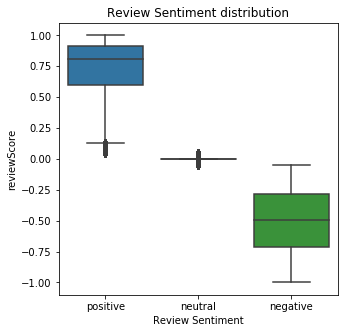

In [23]:
plt.figure(figsize=(5,5))
sns.boxplot(x="label", y="reviewScore", data=df_product_review,order=["positive", "neutral","negative"])
plt.xlabel("Review Sentiment")
plt.title("Review Sentiment distribution")
plt.show()

Analysis the statistic of sentiment score of total reviews,positive reviews, neutral reviews and negative reviews.

### Sub-categories

Difference analysis of each sub-categories (2nd)

In [24]:
df_product_cat_review = df_product_review.copy()

def find_subcat(x):
    if(len(x[0])==1):
        # if second category is None
        return 'default'
    else:
        return x[0][1]

df_product_cat_review["subcategories"] = df_product_cat_review["categories"].apply(lambda x:find_subcat(x))
df_product_cat_review = df_product_cat_review[["subcategories","reviewScore","overall","reviewScoreNorm"]]
df_product_cat_review.head()

,subcategories,reviewScore,overall,reviewScoreNorm
0,default,0.2263,5,3.4526
1,Personal Care,0.9748,5,4.9496
2,Personal Care,0.8313,5,4.6626
3,Personal Care,0.9984,5,4.9968
4,Personal Care,0.4664,2,3.9328


In [25]:
df_product_cat_group = df_product_cat_review.groupby('subcategories').mean().sort_values('reviewScore',ascending = False)
df_product_cat_group

,reviewScore,overall,reviewScoreNorm
subcategories,,,
Baby & Child Care,0.609269,4.205483,4.218539
Stationery & Party Supplies,0.602765,4.102568,4.205530
Sports Nutrition,0.589311,4.237650,4.178623
Personal Care,0.519627,4.102509,4.039254
Household Supplies,0.518710,4.192494,4.037421
default,0.490678,4.019077,3.981356
Sexual Wellness,0.486434,3.694860,3.972868
Medical Supplies & Equipment,0.485439,4.071935,3.970878
Health Care,0.458111,4.127009,3.916223


Plot the distribution of sentiment score for each category.

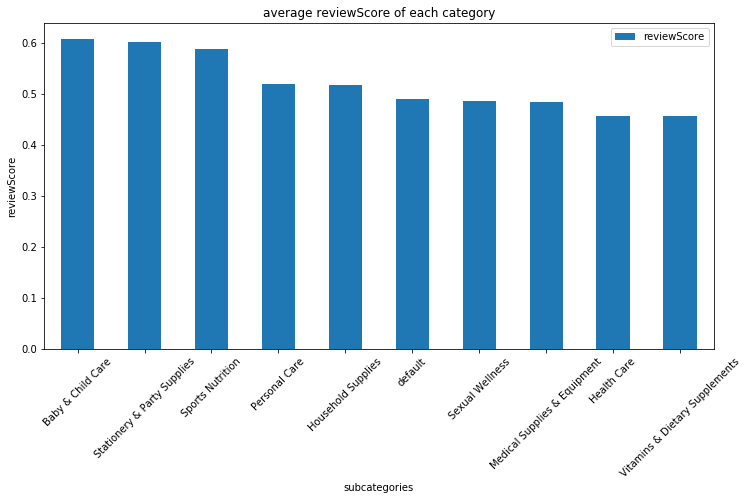

In [26]:
df_product_cat_group.plot.bar(y='reviewScore', rot=45,figsize=(12,6),color='C0')
plt.ylabel("reviewScore")
plt.title("average reviewScore of each category")
plt.show()

Get difference of sentiment score in each category

In [27]:
df_product_cat_group["Diff"] = df_product_cat_group["reviewScoreNorm"] - df_product_cat_group["overall"]
df_product_cat_group

,reviewScore,overall,reviewScoreNorm,Diff
subcategories,,,,
Baby & Child Care,0.609269,4.205483,4.218539,0.013055
Stationery & Party Supplies,0.602765,4.102568,4.205530,0.102962
Sports Nutrition,0.589311,4.237650,4.178623,-0.059027
Personal Care,0.519627,4.102509,4.039254,-0.063255
Household Supplies,0.518710,4.192494,4.037421,-0.155073
default,0.490678,4.019077,3.981356,-0.037721
Sexual Wellness,0.486434,3.694860,3.972868,0.278008
Medical Supplies & Equipment,0.485439,4.071935,3.970878,-0.101057
Health Care,0.458111,4.127009,3.916223,-0.210786


Plot the difference in each category between rating and sentiment score.

In [28]:
df_cat_diff = df_product_cat_group.loc[:,["overall","reviewScoreNorm"]]
df_cat_diff = df_cat_diff.stack()
df_cat_diff = df_cat_diff.to_frame()
df_cat_diff.reset_index(inplace=True)
df_cat_diff.columns = df_cat_diff.columns.astype(str)
df_cat_diff.rename(columns={"level_1":"scoretype","0":"score"},inplace=True)
df_cat_diff.loc[df_cat_diff["scoretype"]=='overall','scoretype'] = 'rating'

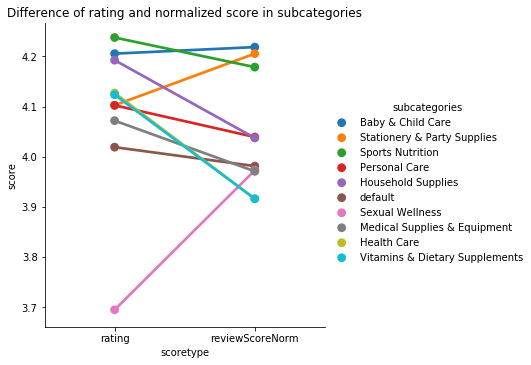

In [29]:
sns.catplot(x="scoretype", y="score",hue="subcategories", kind="point", data=df_cat_diff)
plt.title("Difference of rating and normalized score in subcategories")
plt.show()

Absolute difference analysis

In [30]:
df_product_cat_group["absDiff"] = abs(df_product_cat_group["Diff"])
df_product_cat_group.sort_values("absDiff")

,reviewScore,overall,reviewScoreNorm,Diff,absDiff
subcategories,,,,,
Baby & Child Care,0.609269,4.205483,4.218539,0.013055,0.013055
default,0.490678,4.019077,3.981356,-0.037721,0.037721
Sports Nutrition,0.589311,4.237650,4.178623,-0.059027,0.059027
Personal Care,0.519627,4.102509,4.039254,-0.063255,0.063255
Medical Supplies & Equipment,0.485439,4.071935,3.970878,-0.101057,0.101057
Stationery & Party Supplies,0.602765,4.102568,4.205530,0.102962,0.102962
Household Supplies,0.518710,4.192494,4.037421,-0.155073,0.155073
Vitamins & Dietary Supplements,0.458098,4.123549,3.916197,-0.207352,0.207352
Health Care,0.458111,4.127009,3.916223,-0.210786,0.210786


## Rating VS ReviewScore

Correlation

In [31]:
# the correlation efficience between overall and reviewScoreNorm
df_product_review.corr(method="pearson").iloc[1,2]

0.445401965394518

Difference Analysis

In [32]:
df_product_review["Diff"] = df_product_review["reviewScoreNorm"] - df_product_review["overall"]
df_product_review.head()

,asin,title,reviewText,ReviewTime,categories,reviewScore,overall,reviewScoreNorm,month-day,label,Diff
0,0077614992,Principles of Mgmt + Oper-CSUF Custom C,This book was a requirement for a college clas...,2013-02-15,[[Health & Personal Care]],0.2263,5,3.4526,02-15,positive,-1.5474
1,0615208479,Brain Fitness Exercises Software,This is a great gift for anyone who wants to h...,2008-12-01,"[[Health & Personal Care, Personal Care]]",0.9748,5,4.9496,12-01,positive,-0.0504
2,0615269990,Occam's Razor,Very helpful in learning about different disea...,2014-04-06,"[[Health & Personal Care, Personal Care, Shavi...",0.8313,5,4.6626,04-06,positive,-0.3374
3,0615269990,Occam's Razor,Occam's Razor is an unbelievably intuitive and...,2013-12-04,"[[Health & Personal Care, Personal Care, Shavi...",0.9984,5,4.9968,12-04,positive,-0.0032
4,0615269990,Occam's Razor,I met the guys from Nerdcore at a medical conf...,2014-04-24,"[[Health & Personal Care, Personal Care, Shavi...",0.4664,2,3.9328,04-24,positive,1.9328


Plot the difference distribution

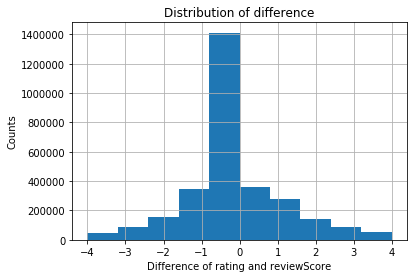

In [33]:
df_product_review["Diff"].hist(bins=10)
plt.xlabel("Difference of rating and reviewScore")
plt.ylabel("Counts")
plt.title("Distribution of difference")
plt.show()

set threshold representing that the reviewScore is consistent with the rating, otherwise it's not.

In [34]:
#the number of inconsistence and consistence
threshold = 1.0
diff_g1 = len(df_product_review[(df_product_review["Diff"]>threshold) | (df_product_review["Diff"]<(-1)*threshold)])
diff_s1 = len(df_product_review[(df_product_review["Diff"]<=threshold) & (df_product_review["Diff"]>=(-1)*threshold)])

print("The number of consistent rating with difference which is not greater than one is {s1}, and occupies {p:.3f}% in reviews"\
                                                          .format(s1=diff_s1,p=diff_s1*100/total_num))
print("The number of inconsistent rating with difference which is greater than one is {g1}, and occupies {p:.3f}% in reviews"\
                                                          .format(g1=diff_g1,p=diff_g1*100/total_num))

The number of consistent rating with difference which is not greater than one is 2053019, and occupies 69.051% in reviews
The number of inconsistent rating with difference which is greater than one is 920167, and occupies 30.949% in reviews


In [35]:
df_diff_g1 = df_product_review[(df_product_review["Diff"]>threshold) | (df_product_review["Diff"]<(-1)*threshold)]

df_diff_g1["absDiff"] = abs(df_diff_g1["Diff"])
df_diff_g1["absDiff"].describe()

count    920167.000000
mean          2.032174
std           0.792226
min           1.000200
25%           1.363600
50%           1.873400
75%           2.592000
max           4.000000
Name: absDiff, dtype: float64

- high sentiment score but with low rating
- low sentiment score but with high rating

Percentage of large difference for two situations.

In [36]:
High_score_low_rat = df_product_review[df_product_review["Diff"]>1].sort_values("Diff",ascending=False)
High_score_low_rat.head()

,asin,title,reviewText,ReviewTime,categories,reviewScore,overall,reviewScoreNorm,month-day,label,Diff
2026735,B004V503B6,OMEGA III Maxx - Omega 3 Pharmaceutical Grade ...,*This is a side-by-side comparison of Omega II...,2013-03-01,"[[Health & Personal Care, Vitamins & Dietary S...",1.0000,1,5.0000,03-01,positive,4.0000
1911198,B004F4PR6Y,Deluxe Tattoo Kit 2 Machine Gun Power Supply N...,"Let Me Start Out By Saying I Did NOT Purchase,...",2013-11-03,"[[Health & Personal Care, Personal Care, Body ...",1.0000,1,5.0000,11-03,positive,4.0000
1465370,B002NXTOJK,"Omega 3's Anti-Inflammatory 60ct Bottle, Arthr...",*This is a side-by-side comparison of Omega XL...,2013-08-26,"[[Health & Personal Care, Health Care, Pain Re...",0.9999,1,4.9998,08-26,positive,3.9998
2570936,B009P6632O,# 1 Omega Xl New Zealand - Powerful Omega 3 &q...,*This is a side-by-side comparison of Omega XL...,2013-10-27,"[[Health & Personal Care, Vitamins & Dietary S...",0.9999,1,4.9998,10-27,positive,3.9998
2746538,B00CDGJIAW,2000mg FISH OIL OMEGA 3 SUPPLEMENTS - Triple S...,*This is a side-by-side comparison of Pacific ...,2013-07-22,"[[Health & Personal Care, Vitamins & Dietary S...",0.9999,1,4.9998,07-22,positive,3.9998


In [37]:
print("The percentage of sentiment with high sentiment score but low rating is :{p:.3f}%".format(p=len(High_score_low_rat)*100/diff_g1))

The percentage of sentiment with high sentiment score but low rating is :43.987%


In [38]:
Low_score_high_rat = df_product_review[df_product_review["Diff"]<-1].sort_values("Diff",ascending=True)
Low_score_high_rat.head()

,asin,title,reviewText,ReviewTime,categories,reviewScore,overall,reviewScoreNorm,month-day,label,Diff
1072320,B001E0STN0,American Biotech Labs Silver Biotics 16 oz ( M...,Here are a couple of exerts from the informati...,2014-05-03,"[[Health & Personal Care, Vitamins & Dietary S...",-0.9999,5,1.0002,05-03,negative,-3.9998
1641763,B0039PH51K,"Acupressure Mat Spike Body Mat for stress, nec...",I was skeptical when I first read about this. ...,2013-01-23,"[[Health & Personal Care, Health Care, Alterna...",-0.9997,5,1.0006,01-23,negative,-3.9994
1439810,B002K4UBCQ,1st grade BiLuoChun Green Tea 100g Gift Box-Ne...,Green Tea Ingredient Slows Breast Cancer-Antio...,2009-09-26,"[[Health & Personal Care, Vitamins & Dietary S...",-0.9995,5,1.0010,09-26,negative,-3.9990
1440258,B002K6FRX2,Yuexi Cuilan (Yuexi Green Orchid Tea) - Organi...,Yuexi Cuilan (Yuexi Green Orchid Tea) - Organi...,2009-09-26,[[Health & Personal Care]],-0.9994,5,1.0012,09-26,negative,-3.9988
1439493,B002K2MUUY,"Lipton Green Tea - 100% Natural, New Spring Gr...",Green Tea Ingredient Slows Breast Cancer-Antio...,2009-09-26,[[Health & Personal Care]],-0.9994,5,1.0012,09-26,negative,-3.9988


In [39]:
print("The percentage of sentiment with low sentiment score but high rating is :{p:.3f}%".format(p=len(Low_score_high_rat)*100/diff_g1))

The percentage of sentiment with low sentiment score but high rating is :56.013%


## Attitude Analysis

sub-categories

In [40]:
df_product_cat_group

,reviewScore,overall,reviewScoreNorm,Diff,absDiff
subcategories,,,,,
Baby & Child Care,0.609269,4.205483,4.218539,0.013055,0.013055
Stationery & Party Supplies,0.602765,4.102568,4.205530,0.102962,0.102962
Sports Nutrition,0.589311,4.237650,4.178623,-0.059027,0.059027
Personal Care,0.519627,4.102509,4.039254,-0.063255,0.063255
Household Supplies,0.518710,4.192494,4.037421,-0.155073,0.155073
default,0.490678,4.019077,3.981356,-0.037721,0.037721
Sexual Wellness,0.486434,3.694860,3.972868,0.278008,0.278008
Medical Supplies & Equipment,0.485439,4.071935,3.970878,-0.101057,0.101057
Health Care,0.458111,4.127009,3.916223,-0.210786,0.210786


``Explanation``

For each product

In [41]:
# for each product
df_average_product = df_product_review[["asin","reviewScore"]]
df_average_product = df_average_product.groupby("asin").mean()

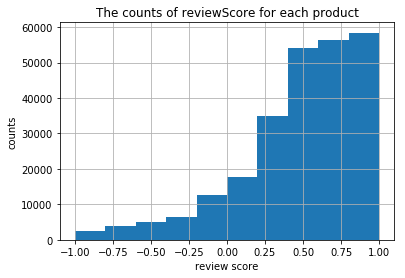

In [42]:
# plot distribution for total
df_average_product["reviewScore"].hist(bins=10)
plt.xlabel("review score")
plt.ylabel("counts")
plt.title("The counts of reviewScore for each product")
plt.show()

In [43]:
df_review_g1 = df_product_review.groupby("asin").count()[["title"]]
df_review_g1 = df_review_g1[df_review_g1["title"]>5]
asin = df_review_g1.index.values
asin = list(asin)
df_review_g1.columns = ['Counts']
df_product_review_g1 = df_product_review[df_product_review['asin'].isin(asin)]
df_product_review_g1 = df_product_review_g1.groupby("asin").mean()
df_product_review_g1['Counts'] = df_review_g1['Counts']
df_product_review_g1 = df_product_review_g1.loc[:,df_product_review_g1.columns!='Diff']

In [44]:
df_product_info = df_product_review[['asin','title','categories']]
df_product_info = df_product_info.drop_duplicates(["asin"])
df_product_info.head()

,asin,title,categories
0,0077614992,Principles of Mgmt + Oper-CSUF Custom C,[[Health & Personal Care]]
1,0615208479,Brain Fitness Exercises Software,"[[Health & Personal Care, Personal Care]]"
2,0615269990,Occam's Razor,"[[Health & Personal Care, Personal Care, Shavi..."
5,0615315860,101 BlenderBottle Recipes Quick and Easy,[[Health & Personal Care]]
7,0615406394,"Aphrodite Reborn - Women's Stories of Hope, Co...",[[Health & Personal Care]]


In [45]:
df_product_review_subset = df_product_review_g1.merge(df_product_info,left_index=True,right_on='asin')
df_product_review_subset = df_product_review_subset[['asin','title','categories','reviewScore','overall','reviewScoreNorm']]
df_product_review_subset['Diff'] = df_product_review_subset['reviewScoreNorm'] - df_product_review_subset['overall']
top10_product = df_product_review_subset.sort_values(by=["reviewScoreNorm","overall"],ascending=False).head(10)

In [46]:
top10_product

,asin,title,categories,reviewScore,overall,reviewScoreNorm,Diff
1761381,B003USZZ2W,Solarrific P7002 Handcrank Personal Shaver,"[[Health & Personal Care, Personal Care, Shavi...",0.975075,3.750000,4.950150,1.200150
2970136,B00JF41NS0,"Coromega Be Bright Superfood Oil Blend, Coconu...","[[Health & Personal Care, Vitamins & Dietary S...",0.970183,5.000000,4.940367,-0.059633
1159298,B001G909FK,Intentional Chocolate Caramel Squares - 6 pieces,"[[Health & Personal Care, Health Care, Stress ...",0.969283,5.000000,4.938567,-0.061433
1472884,B002PEXR2W,"Inward Journey, Learn to Breath Again, A Yoga ...",[[Health & Personal Care]],0.967083,5.000000,4.934167,-0.065833
2981279,B00KXS6LRU,Vitavana&#153; Omega-3 Krill Oil &#10030; 1000...,"[[Health & Personal Care, Vitamins & Dietary S...",0.966217,5.000000,4.932433,-0.067567
1542750,B002XDQIUI,"J.R. Watkins All Purpose Cleaner, Orange Citru...","[[Health & Personal Care, Household Supplies, ...",0.965800,4.333333,4.931600,0.598267
2859954,B00F2KZVOI,"NuZest Clean Lean Protein (pea), Vanilla, 1.1 ...","[[Health & Personal Care, Sports Nutrition, Pr...",0.965683,4.833333,4.931367,0.098033
1325595,B0025ZO1LW,Valobra Almond Soft Shaving Soap,"[[Health & Personal Care, Personal Care, Shavi...",0.964917,3.666667,4.929833,1.263167
252854,B0007XQ2W0,Castle Forbes Lime Oil Aftershave Balm,"[[Health & Personal Care, Personal Care, Shavi...",0.964117,4.500000,4.928233,0.428233
866478,B0012TOC2K,&quot;I'm Grateful You're My Friend&quot; Touc...,"[[Health & Personal Care, Health Care, Massage...",0.963633,5.000000,4.927267,-0.072733


In [47]:
top10_product["subcategories"] = top10_product["categories"].apply(lambda x:find_subcat(x))
top10_product["subcategories"].value_counts()

Personal Care                     3
Vitamins & Dietary Supplements    2
Health Care                       2
default                           1
Household Supplies                1
Sports Nutrition                  1
Name: subcategories, dtype: int64

In [48]:
top10_product["title"].values

array(['Solarrific P7002 Handcrank Personal Shaver',
       'Coromega Be Bright Superfood Oil Blend, Coconut Chia, 10.6 Ounce',
       'Intentional Chocolate Caramel Squares - 6 pieces',
       'Inward Journey, Learn to Breath Again, A Yoga Meditation by Marianne Wells',
       'Vitavana&#153; Omega-3 Krill Oil &#10030; 1000mg Daily with EPA/DHA and Astaxanthin &#10030; Promotes Joint &amp; Heart Health, Weight Loss and Supports Healthy Cholesterol Levels Already In The Normal Range &#10030; Moleculary Distilled for Purity &#10030; 100% Money-Back Guarantee!',
       'J.R. Watkins All Purpose Cleaner, Orange Citrus, 24-Ounce Bottles (Pack of 6)',
       'NuZest Clean Lean Protein (pea), Vanilla, 1.1 pounds',
       'Valobra Almond Soft Shaving Soap',
       'Castle Forbes Lime Oil Aftershave Balm',
       "&quot;I'm Grateful You're My Friend&quot; Touching 8x10 Poem, Double-matted in White Over Royal Blue and Enhanced with Watercolor Graphics. A Gift For A Friend."],
      dtype=object

``Explanation``

### Trend of popularity as time goes.

In [49]:
df_time_popularity = df_product_review.groupby("ReviewTime").mean()[["reviewScoreNorm"]]

In [50]:
df_time_popularity.head()

,reviewScoreNorm
ReviewTime,
1999-10-20,1.5984
1999-11-02,3.7604
2000-03-16,4.6394
2000-04-28,4.7086
2000-04-29,4.1218


In [51]:
df_time_popularity.reset_index(inplace=True)
flag = df_time_popularity['ReviewTime'].map(lambda x: (x.year>2003)&((x.year<2014)))
df_time_popularity_subset = df_time_popularity.loc[flag]

In [52]:
df_time_popularity_subset.head()

,ReviewTime,reviewScoreNorm
832,2004-01-01,4.647871
833,2004-01-02,4.549967
834,2004-01-03,4.861120
835,2004-01-04,4.003660
836,2004-01-05,3.882657


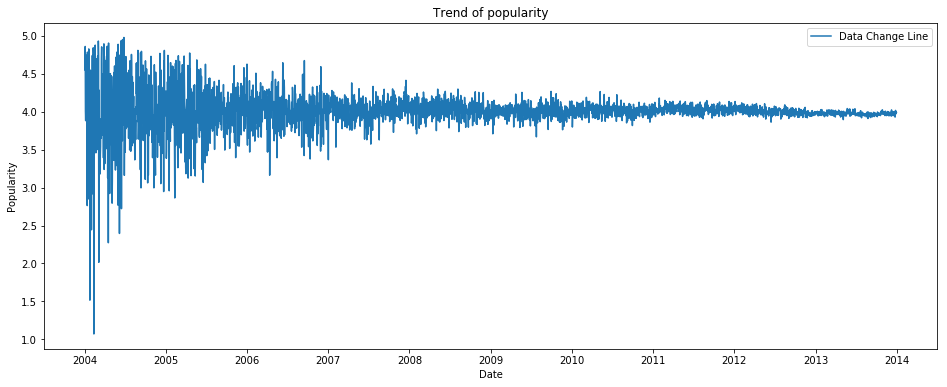

In [53]:
plt.figure(figsize=(16,6))
plt.plot(df_time_popularity_subset.ReviewTime, df_time_popularity_subset.reviewScoreNorm)
plt.xlabel('Date')
plt.ylabel('Popularity')
plt.title('Trend of popularity')
plt.legend(['Data Change Line'])
plt.show()

``Explanation``

以月为单位再画一个走向图

In [54]:
df_product_review.dtypes

asin                       object
title                      object
reviewText                 object
ReviewTime         datetime64[ns]
categories                 object
reviewScore               float64
overall                     int64
reviewScoreNorm           float64
month-day                  object
label                      object
Diff                      float64
dtype: object

In [55]:
df_product_review["Yearmonth"] = df_product_review['ReviewTime'].apply(lambda x: x.strftime('%Y-%m'))

In [56]:
df_product_review.sort_values('Yearmonth').head(3)

,asin,title,reviewText,ReviewTime,categories,reviewScore,overall,reviewScoreNorm,month-day,label,Diff,Yearmonth
2798,B00000JHQ7,Duracell MN1500B8 AA (8-Pack),I expected so much and yet recieved so little ...,1999-10-20,"[[Health & Personal Care, Household Supplies, ...",-0.7008,1,1.5984,10-20,negative,0.5984,1999-10
2492,B00000JHQ0,NaN,I've used these batteries my entire life in ev...,1999-11-02,[[Health & Personal Care]],0.3802,5,3.7604,11-02,positive,-1.2396,1999-11
2197,B00000J47L,Energizer Power Plus NiMH AA Rechargeable Batt...,I bought a bunch of Energizer's AA ACCU NiMH r...,2000-03-16,"[[Health & Personal Care, Household Supplies]]",0.8197,4,4.6394,03-16,positive,0.6394,2000-03


In [57]:
df_month_popularity = df_product_review.groupby("Yearmonth").mean()[["reviewScoreNorm"]]
df_month_popularity.reset_index(inplace=True)
df_month_popularity['Yearmonth'] = pd.to_datetime(df_month_popularity['Yearmonth'])
flag = df_month_popularity['Yearmonth'].map(lambda x: (x.year>2003)&((x.year<2014)))
df_month_popularity_subset = df_month_popularity.loc[flag]
df_month_popularity_subset.head()

,Yearmonth,reviewScoreNorm
48,2004-01-01,4.083851
49,2004-02-01,4.137329
50,2004-03-01,4.040955
51,2004-04-01,3.930255
52,2004-05-01,3.999891


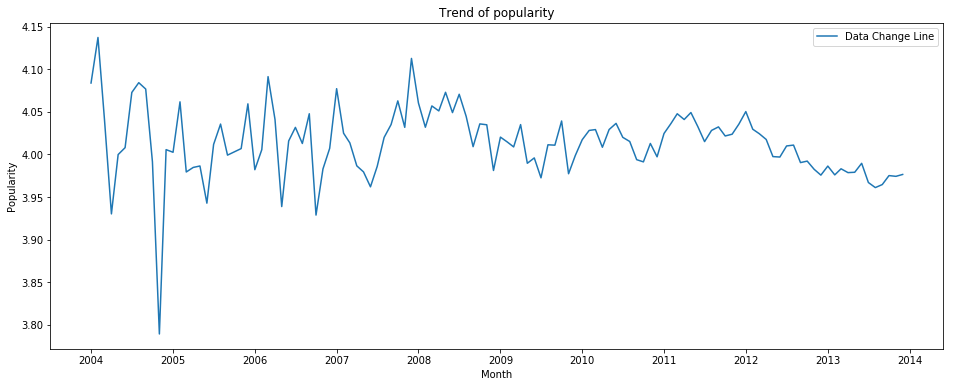

In [58]:
plt.figure(figsize=(16,6))
plt.plot(df_month_popularity_subset.Yearmonth, df_month_popularity_subset.reviewScoreNorm)
plt.xlabel('Month')
plt.ylabel('Popularity')
plt.title('Trend of popularity')
plt.legend(['Data Change Line'])
plt.show()

In [5]:
def interested_day(df,interested_day_name,month,day):
    # a week
    df['month-day'] = df['ReviewTime'].apply(lambda x: x.strftime('%m-%d'))
    date = datetime.datetime.strptime(str(month)+'-'+str(day),"%m-%d")
    delta = datetime.timedelta(days=7)
    
    date_period = (date+delta).strftime('%m-%d')
    date_period_month = (date+delta).strftime('%m')
    date_start  = date.strftime('%m-%d')
    date_start_month  = date.strftime('%m')
    
    
    if date_start_month <= date_period_month:
        interested_day = df[(df['month-day']<date_period)&(df['month-day']>=date_start)]
    else:
        interested_day = df[((df['month-day']>=date_start))&(df['month-day']<='12-31')|(df['month-day']<date_period)]
    return interested_day    

In [13]:
month = 12
day = 25
Christ_review = interested_day(df_product_review,'',month,day)
Christ_review = Christ_review.groupby("asin").mean()[["reviewScore","overall","reviewScoreNorm"]]
Christ_review.describe()

,reviewScore,overall,reviewScoreNorm
count,31178.000000,31178.000000,31178.000000
mean,0.486837,4.101521,3.973674
std,0.462796,1.228849,0.925592
min,-0.997300,1.000000,1.005400
25%,0.259856,3.666667,3.519712
50%,0.636100,4.800000,4.272200
75%,0.850294,5.000000,4.700587
max,0.999300,5.000000,4.998600


In [14]:
month = 4
day = 7
International_health_review = interested_day(df_product_review,'',month,day)
International_health_review = International_health_review.groupby("asin").mean()[["reviewScore","overall","reviewScoreNorm"]]
International_health_review.describe()

,reviewScore,overall,reviewScoreNorm
count,31453.000000,31453.000000,31453.000000
mean,0.482372,4.066575,3.964744
std,0.473912,1.253181,0.947824
min,-0.994500,1.000000,1.011000
25%,0.245700,3.500000,3.491400
50%,0.640271,4.727273,4.280541
75%,0.856000,5.000000,4.712000
max,0.999600,5.000000,4.999200


In [15]:
month = 11
day = 23
blackfri_review = interested_day(df_product_review,'',month,day)
blackfri_review = blackfri_review.groupby("asin").mean()[["reviewScore","overall","reviewScoreNorm"]]
blackfri_review.describe()

,reviewScore,overall,reviewScoreNorm
count,25098.000000,25098.000000,25098.000000
mean,0.479274,4.069485,3.958548
std,0.476605,1.258743,0.953210
min,-0.995700,1.000000,1.008600
25%,0.243950,3.500000,3.487900
50%,0.636900,4.833333,4.273800
75%,0.852637,5.000000,4.705275
max,1.000000,5.000000,5.000000


-----------

## 5. Special Day Analysis

### 5.1 The number of products in each category may influnce the reviews

#### 5.1.1 Consider the average review number for product in each category 

In [9]:
# Groupby
grouped_df = df_health_category.groupby('2nd')

In [10]:
# calculate the review quantity for each category
grouped_df.count()[['overall']]

,overall
2nd,
Baby & Child Care,6930
Health Care,538955
Household Supplies,389269
Medical Supplies & Equipment,479393
Personal Care,601372
Sexual Wellness,105925
Sports Nutrition,147730
Stationery & Party Supplies,43883
Vitamins & Dietary Supplements,576541


In [11]:
# calculate the number of products for each category
grouped_df[['asin']].nunique()

,asin
2nd,
Baby & Child Care,823
Health Care,48520
Household Supplies,31324
Medical Supplies & Equipment,30943
Personal Care,39084
Sexual Wellness,18774
Sports Nutrition,9374
Stationery & Party Supplies,11897
Vitamins & Dietary Supplements,47934


In [12]:
# calculate the average review number for product in each category
aver_cate = pd.DataFrame(grouped_df.count()['overall'].divide(grouped_df[['asin']].nunique()['asin']))
aver_cate.columns = ['average_review_number']
aver_cate = aver_cate.sort_values('average_review_number',ascending = False)
aver_cate

,average_review_number
2nd,
Sports Nutrition,15.759548
Medical Supplies & Equipment,15.492777
Personal Care,15.386654
Household Supplies,12.427180
Vitamins & Dietary Supplements,12.027809
Health Care,11.107894
Baby & Child Care,8.420413
Sexual Wellness,5.642111
Stationery & Party Supplies,3.688577


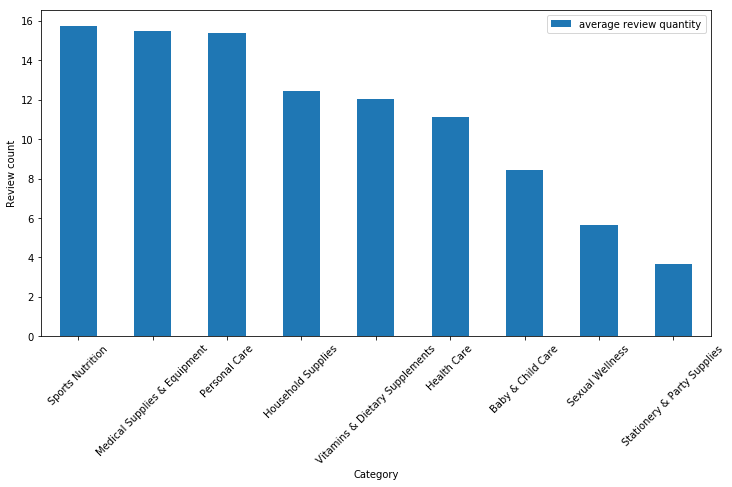

In [13]:
_, ax1 = plt.subplots(figsize = (12,6))
aver_cate.plot.bar(ax=ax1,rot=45)
ax1.legend(labels = ['average review quantity'])
ax1.set_xlabel('Category')
ax1.set_ylabel('Review count')
plt.show()

It is shown that personal product get the largest review quantity and statinary&Party supplies get the smallest review quantity.

#### 5.1.2 Consider the median review number for product in each category 

In [14]:
df_median = df_health_category.groupby(['2nd','asin']).count()[['overall']]

In [15]:
df_median.head(20)

overall
2nd               asin               
Baby & Child Care 8921422722        3
                  8921422749        1
                  9029300965        2
                  9533223510       24
                  9533225181        2
                  B000052YLR       15
                  B0000537CV        3
                  B0000537CW       23
                  B000067QOX        1
                  B00007EFLB        2
                  B0000867HM        1
                  B00008J2X6        1
                  B000093I6R        1
                  B00009WO05        2
                  B0000VLY2W        6
                  B0000Y3CWY       55
                  B0000Y3DW8        5
                  B00014D74Q       29
                  B00014FUBY        7
                  B0001884XG        1

In [16]:
df_median = df_median.groupby(level=[0]).median()
df_median

,overall
2nd,
Baby & Child Care,2
Health Care,2
Household Supplies,2
Medical Supplies & Equipment,2
Personal Care,2
Sexual Wellness,2
Sports Nutrition,3
Stationery & Party Supplies,1
Vitamins & Dietary Supplements,2


Since the median review quantity for product among categories all are the same, 2, this method is not meanful and we ignore this method.

### 5.2  Intersted day analysis in different categoties

In [17]:
def special_day_all_categories(df,special_day_name,year,month,day,list_category_name):
    '''
       Plot rating average and review quantity in special day 
        for different categories 
    
       Parameter: 
       df : a dataframe
       special_day_name : special day's name
       year : selected year
       month : the month of special day
       day : the day of special day
       list_category_name : a name list of category 
    '''
    # A week
    date = datetime.datetime.strptime(str(year)+'-'+str(month)+'-'+str(day),"%Y-%m-%d")
    delta = datetime.timedelta(days=7)
    date_period = date+delta
    
    fig, ax = plt.subplots(2,1,figsize = (12,18))

    N = len(list_category_name)
    width = 0.26

    special_day = df[(df['time'] >= date) & (df['time'] < date_period)]
    special_year = df[df.time.dt.year == year]

    year_len = len(df[df.time.dt.year == year].time.unique())
    
    i_day = special_day.groupby('2nd')[['overall']].mean()
    i_day = i_day[i_day.index.isin(list_category_name)]
    i_year = special_year.groupby('2nd')[['overall']].mean()
    i_year = i_year[i_year.index.isin(list_category_name)]

    ind = np.arange(i_day.shape[0])
    ax[0].bar(ind,i_day.overall.values.tolist(),width,color ='C0')
    ax[0].bar(ind+width,i_year.overall.values.tolist(),width,color ='C1')
    ax[0].legend(labels=[special_day_name,'Day average rating in related year'])
    ax[0].set_xticks(ind+width/2)
    ax[0].set_xticklabels( i_day.index.values.tolist(), rotation=20 )
    ax[0].set_ylim(2.0,4.5)
    ax[0].set_ylabel('Rating average')
    ax[0].set_title('Rating average for each category in ' +special_day_name)

    # Review quantity
    i_day_q = special_day.groupby('2nd')[['overall']].count()/7
    i_day_q = i_day_q[i_day_q.index.isin(list_category_name)]
    i_year_q = special_year.groupby('2nd')[['overall']].count()/year_len
    i_year_q = i_year_q[i_year_q.index.isin(list_category_name)]


    ind_q = np.arange(i_day_q.shape[0])
    ax[1].bar(ind_q,i_day_q.overall.values.tolist(),width,color ='C0')
    ax[1].bar(ind_q+width,i_year_q.overall.values.tolist(),width,color ='C1')
    ax[1].set_xticks(ind+width/2)
    ax[1].set_xticklabels(i_day_q.index.values.tolist(), rotation=20 )
    ax[1].legend(labels=[special_day_name,'Day average review quantity in related year'])
    ax[1].set_ylabel('Review quantity')
    ax[1].set_title('Review quantity for each category in ' +special_day_name)

    plt.show()

In [18]:
# # Review quantity
# grouped_df = special_day.groupby('2nd')
# i_day_q = grouped_df.count()['overall'].divide(grouped_df[['asin']].nunique()['asin'])/7
# i_day_q = i_day_q[i_day_q.index.isin(list_category_name)]

# # i_day_q = special_day.groupby('2nd')[['overall']].count()/7

# grouped_df_year = special_year.groupby('2nd')
# i_year_q = grouped_df_year.count()['overall'].divide(grouped_df_year[['asin']].nunique()['asin'])/year_len
# i_year_q = i_year_q[i_year_q.index.isin(list_category_name)]

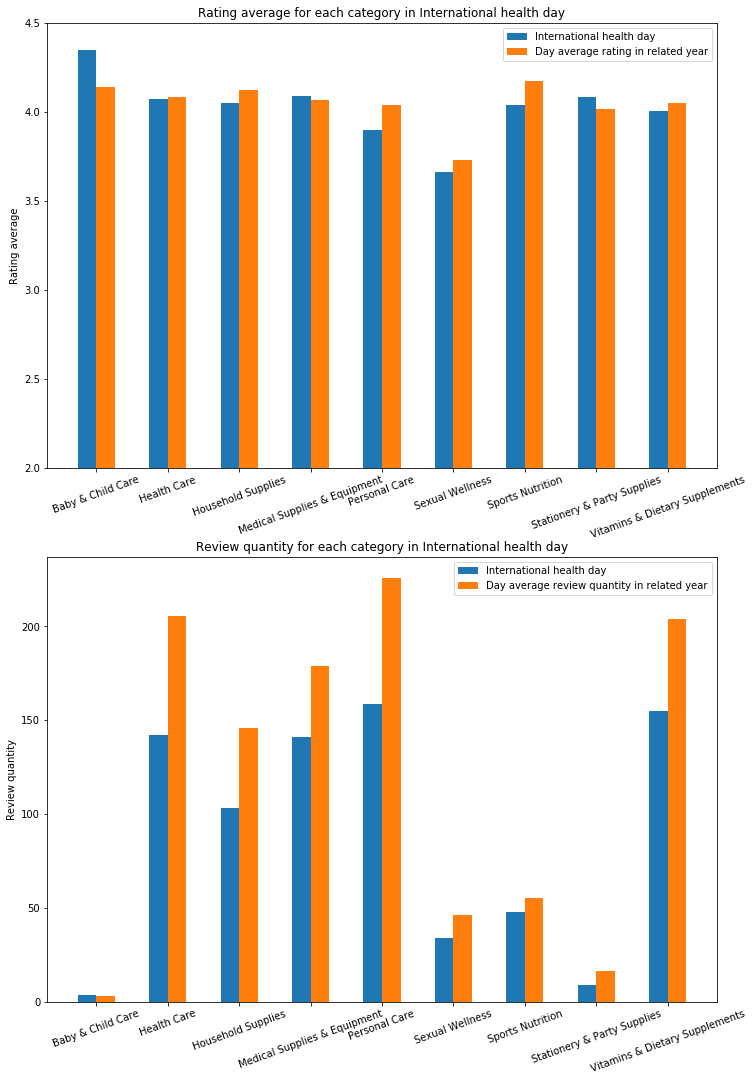

In [19]:
special_day_name = 'International health day'
month = 4
day = 7
year = 2012
df = df_health_category.copy()
list_category_name = df_median.index.values.tolist()
special_day_all_categories(df,special_day_name,year,month,day,list_category_name)

In [20]:
def special_day(df,special_day_name,month,day):
    
    '''
       Plot rating trend and review quantity in special day 
       between 2004-2014 among all categories
    
       Parameter: 
       df : a dataframe
       special_day_name : special day's name
       month : month of special day
       day : day of special day
    '''
    fig, ax = plt.subplots(2,1,figsize = (12,12))
    
    # a week
    df['month-day'] = df['time'].apply(lambda x: x.strftime('%m-%d'))
    date = datetime.datetime.strptime(str(month)+'-'+str(day),"%m-%d")
    delta = datetime.timedelta(days=7)
    
    date_period = (date+delta).strftime('%m-%d')
    date_period_month = (date+delta).strftime('%m')
    date_start  = date.strftime('%m-%d')
    date_start_month  = date.strftime('%m')
    
    
    if date_start_month <= date_period_month:
        special_day = df[(df['month-day']<date_period)&(df['month-day']>=date_start)]
    else:
        special_day = df[((df['month-day']>=date_start))&(df['month-day']<='12-31')|(df['month-day']<date_period)]
    intersted_category = df.copy()

    # Rating average 
    d = special_day.groupby(special_day.time.dt.year)[['overall']].mean()
    d = d.loc[(d.index>2003)& (d.index<2014)]
    d.index = d.index.astype('int')
    d[(d.index>2003) & (d.index<2014)].plot(ax=ax[0])

    inter = intersted_category.groupby(intersted_category.time.dt.year)[['overall']].mean()
    inter = inter.loc[(inter.index>2003) & (inter.index<2014)]
    inter.index = inter.index.astype('int')
    inter[(inter.index>2003) & (inter.index<2014)].plot(ax=ax[0])

    ax[0].legend(labels=[special_day_name,'Day average rating in related year'])
    ax[0].set_xlabel('Year')
    ax[0].set_ylabel('Rating average')
    ax[0].set_title('Rating change among all categories in ' +special_day_name+ ' through years')


    # Reviw quantity
    d_q = special_day.groupby(special_day.time.dt.year)[['overall']].count()/7
    d_q = d_q.loc[(d_q.index>2003) & (d_q.index<2014)]
    d_q.index = d_q.index.astype('int')
    d_q[(d_q.index>2003) & (d_q.index<2014)].plot(ax=ax[1])

    inter_q  = intersted_category.groupby(intersted_category.time.dt.year)[['overall']].count()/365
    inter_q  = inter_q.loc[(inter_q.index>2003) & (inter_q.index<2014)]
    inter_q.index = inter_q.index.astype('int')
    inter_q[(inter_q.index>2003) & (inter_q.index<2014)].plot(ax=ax[1])

    ax[1].legend(labels=[special_day_name,'Day average review quantity in related year'])
    ax[1].set_xlabel('Year')
    ax[1].set_ylabel('Review quantity')
    ax[1].set_title('Review quantity among all categories in ' +special_day_name+ ' through years')

    plt.show()
    return fig

### 5.3 International health day

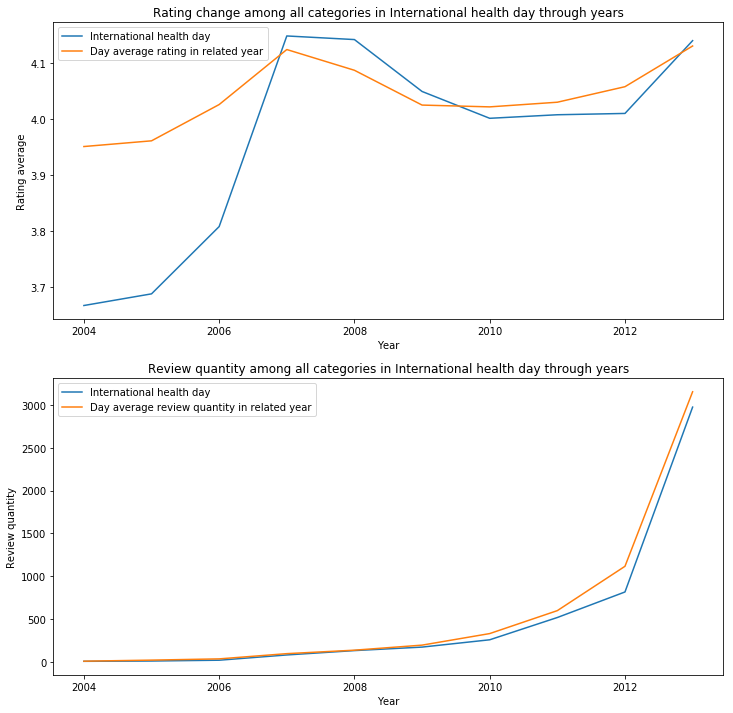

In [21]:
special_day_name = 'International health day'
month = 4
day = 7
df = df_health_category.copy()
cat_name = rating_avg.index.values.tolist()[0]
fig3 = special_day(df,special_day_name,month,day)

#### 5.4 Christmas Day

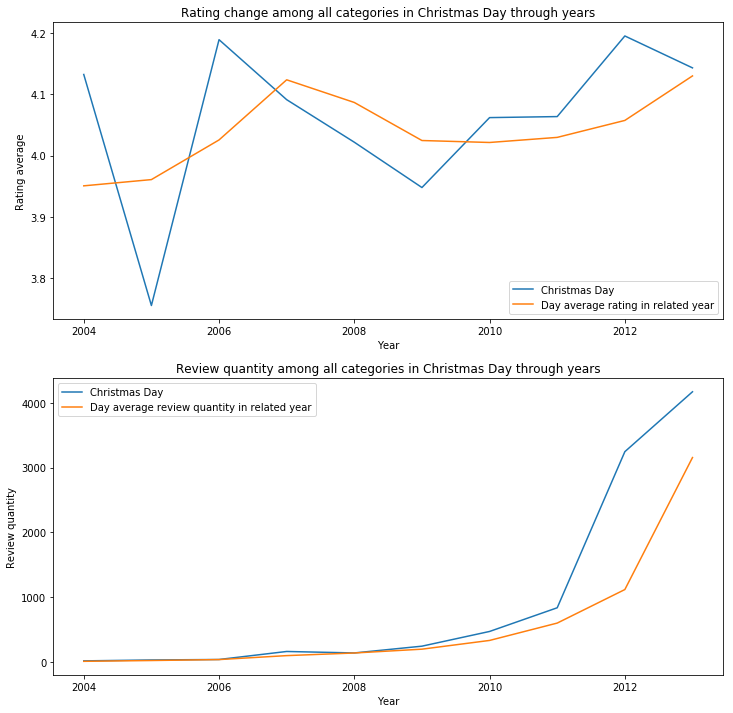

In [22]:
special_day_name = 'Christmas Day'
month = 12
day = 25
df = df_health_category.copy()
cat_name = rating_avg.index.values.tolist()[0]
fig1 = special_day(df,special_day_name,month,day)

### 5.5 Black Friday

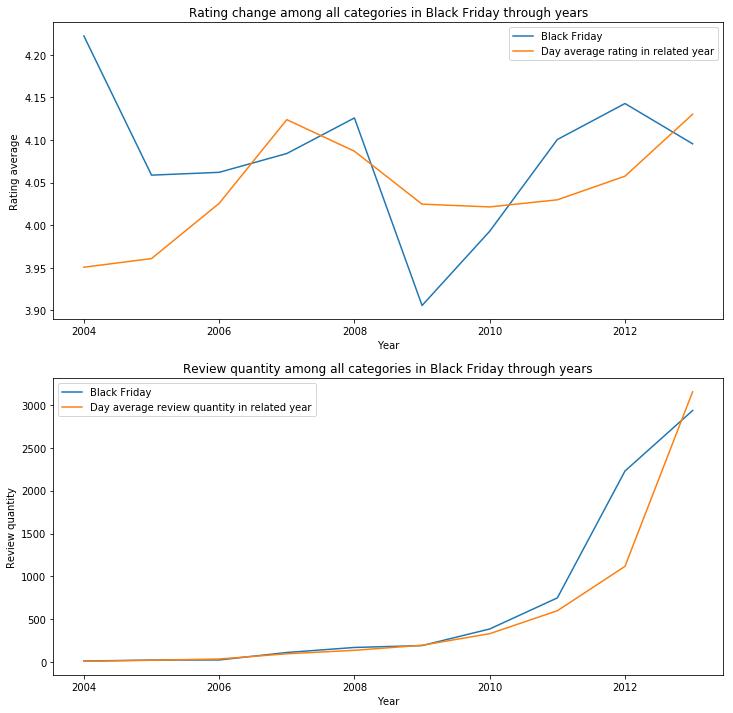

In [23]:
special_day_name = 'Black Friday'
month = 11
day = 23
df = df_health_category.copy()
cat_name = rating_avg.index.values.tolist()[0]
fig2 = special_day(df,special_day_name,month,day)

```Explantion```

After observing above three ling chart figure in three special day, International health day, Christmas Day, Black Friday, It is obvious that the number of review increasing dramatically in these three days but their average rating fluctuate comparing year's avearge raing through 2004-2013

## 6.Conclusion